# Script to predict the MW - M31 orbit 

## About this script <a id='overview'></a>


## Below the imports, there are several sections: 

### (1) [Definitions of global variables and parameters](#definitions) meant to be changed
### (2) [Custom Functions used in the calculation](#functions), including one where [observational values](#observations#) and the different variants are defined.
### (3) A function containing the loop for [computing and saving the orbits and other results](#compute_and_save).
### (4) Functions for [Plotting the figures](#plotting_functions).

### (5) The [main loop](#main_loop), where the functions for orbit integration and plotting can be called.



#### We use the following units throughout:

    * velocity: km/s
    * distance: kpc
    * mass: 10**10 Msun
    * time: Gyr
    * value of G in this system: 43007

In [1]:
# For running on puhti
import sys
sys.path.append('/users/sawalati/.local/lib/python3.10/site-packages')
!{sys.executable} -m pip install --user colossus
!{sys.executable} -m pip  install --user --upgrade numpy

## Imports

In [2]:
#Math librairies
import numpy as np
from tqdm import tqdm
from scipy.interpolate import CubicSpline
import math

from scipy.stats import truncnorm
from scipy.signal import argrelextrema
from scipy.interpolate import griddata

import os

#Astro libraries
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric
from astropy.coordinates import galactocentric_frame_defaults

from astropy import coordinates as coord

from astropy.coordinates import SkyCoord
from astropy.coordinates import Distance

from galpy import potential

from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
cosmo = cosmology.setCosmology('planck18') 

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable


from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

from PIL import Image
from PIL import ImageChops

/tmp/ipykernel_2736/1423537084.py:38: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter



## Definitions and global variables: <a id='definitions'></a>

In [16]:
# Will we calculate the orbits?
calculate_orbits = True

# Will we make the plots?
plot_figures = True

# if save_orbits is true, the full orbits (not only summaries) are saved.
save_orbit = True 

# save the observables
save_observables = True 

fig_format = '.pdf'
#fig_format = '.png'

# Which sets of galaxies will be included (MW and M31 are always assumed to be included. The order is irrelevant.)
galaxies_sets = [['M31', 'MW', 'LMC', 'M33'], ['M31', 'MW', 'M33'], ['M31', 'MW', 'LMC'], ['M31', 'MW']] 

galaxies_sets = [['M31', 'MW', 'LMC', 'M33'], ['M31', 'MW', 'M33'], ['M31', 'MW', 'LMC'], ['M31', 'MW']] 

# what variants for the assumptions about observational values
variants = ['fiducial', 'low-vt', 'vary-constant-masses', 'vary-only-mass', 'low-vt-high-mass', 'light-LMC'] 
variants = ['M31-1p0', 'M31-1p5', 'M31-2', 'M31-2p5', 'M31-3', 'M31-3p5']
variants = ['LMC-0p5', 'LMC-1p0', 'LMC-1p5', 'LMC-2', 'LMC-2p5']

variants = ['M_M31-1p5_sigma', 'M_M31-1p2_sigma', 'M_M31-0p9_sigma', 'M_M31-0p6_sigma', 'M_M31-0p3_sigma', 
            'M_M31+0p0_sigma', 'M_M31+0p3_sigma', 'M_M31+0p6_sigma', 'M_M31+0p9_sigma', 'M_M31+1p2_sigma', 'M_M31+1p5_sigma',
            'M_MW-1p5_sigma', 'M_MW-1p2_sigma', 'M_MW-0p9_sigma', 'M_MW-0p6_sigma', 'M_MW-0p3_sigma', 
            'M_MW+0p0_sigma', 'M_MW+0p3_sigma', 'M_MW+0p6_sigma', 'M_MW+0p9_sigma', 'M_MW+1p2_sigma', 'M_MW+1p5_sigma',
            'M_LMC-1p5_sigma', 'M_LMC-1p2_sigma', 'M_LMC-0p9_sigma', 'M_LMC-0p6_sigma', 'M_LMC-0p3_sigma', 
            'M_LMC+0p0_sigma', 'M_LMC+0p3_sigma', 'M_LMC+0p6_sigma', 'M_LMC+0p9_sigma', 'M_LMC+1p2_sigma', 'M_LMC+1p5_sigma',
            'M_M33-1p5_sigma', 'M_M33-1p2_sigma', 'M_M33-0p9_sigma', 'M_M33-0p6_sigma', 'M_M33-0p3_sigma', 
            'M_M33+0p0_sigma', 'M_M33+0p3_sigma', 'M_M33+0p6_sigma', 'M_M33+0p9_sigma', 'M_M33+1p2_sigma', 'M_M33+1p5_sigma']


galaxies_sets = [['M31', 'MW', 'LMC', 'M33'], ['M31', 'MW', 'M33'], ['M31', 'MW', 'LMC'], ['M31', 'MW']] 
variants = ['precise-dmod']

# what Dynamical Friction model to use
dynamical_frictions = ['proportional', 'hierarchical', 'mutual', 'none']
dynamical_frictions = ['proportional']

# Sigmas for truncating the Gaussians results. (> 20 assumed to be untrancated)
clip_sigmas = [1.5, 1000.0]
clip_sigmas = [1.5]

# How many MC samples to include (The running time is directly proportional to this)
N_s = 100

plots_dir = 'plots_new'     # the directory where the plots will be put. Attempt to create if it does not exist.
orbits_dir = 'orbits'  # the directory where the orbits will be put. Attempt to create if it does not exist.
animations_dir = 'animations'  # the directory where the orbits will be put. Attempt to create if it does not exist.


# Simulation time in Gyr
tEnd      = 10     # time at which simulation ends
dt        = .001   # timestep (The running time is almost directly inversely proportional to this)
Nt = int(np.ceil(tEnd/dt))
t_all = np.arange(Nt+1)*dt

softening = 20 # gravitational softening in kpc
merger_threshold = 20 # galaxies are merged at this distance (in kpc)

G = 43007 # Gravitational constant in appropriate units. Don't change this!

# size of the bitmap images
N_pixels = 1200

# color maps
cmapMW = cm.viridis
cmapMW.set_under('black')

cmapM31 = cm.magma
cmapM31.set_under('black')

cmapLMC = cm.Greys_r
cmapLMC.set_under('black')

cmapalt = cm.Blues_r
cmapalt.set_under('black')

cmapMW_premerger = cm.RdPu_r
cmapMW_premerger.set_under('black')

cmapMW_postmerger = cm.Oranges_r
cmapMW_postmerger.set_under('black')


## Set galactocentric frame to v 4.0 (latest version available at the time of writing)

In [17]:
test = galactocentric_frame_defaults.set('v4.0') 
test = Galactocentric()
print (Galactocentric())
print (test.frame_attribute_references)

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>
{'galcen_coord': 'https://ui.adsabs.harvard.edu/abs/2004ApJ...616..872R', 'galcen_distance': 'https://ui.adsabs.harvard.edu/abs/2018A%26A...615L..15G', 'galcen_v_sun': ['https://ui.adsabs.harvard.edu/abs/2018RNAAS...2..210D', 'https://ui.adsabs.harvard.edu/abs/2018A%26A...615L..15G', 'https://ui.adsabs.harvard.edu/abs/2004ApJ...616..872R'], 'z_sun': 'https://ui.adsabs.harvard.edu/abs/2019MNRAS.482.1417B', 'roll': None}


## Functions <a id='functions'></a>

In [18]:
def indexes(galaxies):
    """
    Returns the array indices of the optional galaxies
    """
    idx_LMC = -1
    idx_M33 = -1
    idx_M32 = -1
    idx_SMC = -1
    
    if 'LMC' in galaxies:
        idx_LMC = 2
    if 'M33' in galaxies: # but not the LMC
        idx_M33 = 2
    if 'LMC' in galaxies and 'M33' in galaxies:
        idx_LMC = 2; idx_M33 = 3
    if 'M32' and 'SMC' in galaxies:
        idx_M32 = 4; idx_SMC = 5

    return idx_LMC, idx_M33, idx_M32, idx_SMC

### Set the observational values <a id='observations'></a>

In [19]:
def DefineParameters(variant, galaxies):
    """
    Sets the values of observational parameters.
    """

# Fiducial model:

    # MW
    m_MW_mean, m_MW_sigma = (100, 20)
    c_MW_mean, c_MW_sigma = (10, 2)
    
    # M31
    m_M31_mean, m_M31_sigma = (150, 50) 
    dmod_M31_mean, dmod_M31_sigma = (24.45, 0.10)
    pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma = (48.9, 10.5) 
    pm_dec_M31_mean, pm_dec_M31_sigma = (-36.9, 8.1)
    vr_M31_mean, vr_M31_sigma = (-301, 5)
    c_M31_mean, c_M31_sigma = (10, 2)
    
    # M33
    m_M33_mean, m_M33_sigma = (40, 15)
    dmod_M33_mean, dmod_M33_sigma = (24.67, 0.07)
    pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma = (31, 19)
    pm_dec_M33_mean, pm_dec_M33_sigma = (-29, 16)
    vr_M33_mean, vr_M33_sigma = (-179.2, 3) 
    c_M33_mean, c_M33_sigma = (10,2)
    
    # LMC
    m_LMC_mean, m_LMC_sigma = (16., 5.)
    dmod_LMC_mean, dmod_LMC_sigma = (18.477, 0.026)
    pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma = (1910, 20) 
    pm_dec_LMC_mean, pm_dec_LMC_sigma = (229, 47) 
    vr_LMC_mean, vr_LMC_sigma = (262.2, 3.4)
    c_LMC_mean, c_LMC_sigma = (10,2)

    # SMC
    m_SMC_mean, m_SMC_sigma = (1.5, 0.5)
    dmod_SMC_mean, dmod_SMC_sigma = (18.99, 0.03) # cioni 2000
    pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma = (772, 63) 
    pm_dec_SMC_mean, pm_dec_SMC_sigma = (-1117, 61) 
    vr_SMC_mean, vr_SMC_sigma = (145.6, 0.6)  # (Harris & Zaritsky 2006)
    c_SMC_mean, c_SMC_sigma = (10,2)

    # M32
    m_M32_mean, m_M32_sigma = (1.5, 0.5)
    dmod_M32_mean, dmod_M32_sigma = (18.99, 0.03) # cioni 2000
    pm_ra_cosdec_M32_mean, pm_ra_cosdec_M32_sigma = (772, 63) 
    pm_dec_M32_mean, pm_dec_M32_sigma = (-1117, 61) 
    vr_M32_mean, vr_M32_sigma = (-199, 6.0)  # McConnachie
    c_M32_mean, c_M32_sigma = (10,2)

    # IC10
    m_M32_mean, m_M32_sigma = (1.5, 0.5)
    dmod_M32_mean, dmod_M32_sigma = (18.99, 0.03) # cioni 2000
    pm_ra_cosdec_M32_mean, pm_ra_cosdec_M32_sigma = (37, 4) 
    pm_dec_M32_mean, pm_dec_M32_sigma = (-11, 1) 
    vr_M32_mean, vr_M32_sigma = (-344, 3.0)  # McConnachie
    c_M32_mean, c_M32_sigma = (10,2)

    
#(α, δ) = (16fdg25, −72fdg42) (Stanimirović et al. 2004), the distance modulus fixed at m − M = 18.99 (Cioni et al. 2000), and the radial velocity fixed at vsys = 145.6 km s−1 (Harris & Zaritsky 2006).
    
#    −1.910±0.02
#    0.229±0.047
#    −0.772±0.063
#    −1.117±0.061

    # MW is always 0
    # M31 is always 1
    idx_LMC, idx_M33, idx_M32, idx_SMC = indexes(galaxies)

    # variants have different combinations of observational values
    
    match variant:
        case 'fiducial':
            print ('fiducial (all default values)')

        case 'fiducial-most-likely':
            m_MW_sigma = 0
            c_MW_sigma = 0
            
            # M31
            m_M31_sigma = 0
            dmod_M31_sigma = 0
            pm_ra_cosdec_M31_sigma = 0
            pm_dec_M31_sigma = 0
            vr_M31_sigma = 0
            c_M31_sigma = 0
            
            # M33
            m_M33_sigma = 0
            dmod_M33_sigma = 0
            pm_ra_cosdec_M33_sigma = 0
            pm_dec_M33_sigma = 0
            vr_M33_sigma = 0 
            c_M33_sigma = 0
            
            # LMC
            m_LMC_sigma = 0
            dmod_LMC_sigma = 0
            pm_ra_cosdec_LMC_sigma = 0 
            pm_dec_LMC_sigma = 0 
            vr_LMC_sigma = 0
            c_LMC_sigma = 0

            
            print ('fiducial (most likely)')
        

        case 'new':
            dmod_M31_mean, dmod_M31_sigma = (24.407, 0.032)
            m_M33_mean, m_M33_sigma = (20, 5)
            
            print ('new')
            
    
        case 'vdM2019':
            pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma = (49, 11)
            pm_dec_M31_mean, pm_dec_M31_sigma = (-38, 11)
            print ('Van der Marel 2019')
            
        case 'vdM2019_ML':
            dmod_M31_mean, dmod_M31_sigma = (24.407, 0.032)
            m_M33_mean, m_M33_sigma = (20, 5)
            pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma = (49, 11)
            pm_dec_M31_mean, pm_dec_M31_sigma = (-38, 11)
            print ('Van der Marel 2019 most likely')

        case 'radial':
            pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma = (38.04, 0)
            pm_dec_M31_mean, pm_dec_M31_sigma = (-21.37, 0)
            print ('radial')
    
        case 'high-M-M31':
            m_M31_mean = 200
            print ('High M M31')
    
        case 'vary-constant-masses':
            m_MW_sigma = 0
            m_M31_sigma = 0
            m_LMC_sigma = 0
            m_M33_sigma = 0
            print ('set mass variation to zero')
    
        case 'vary-only-mass':
            dmod_M31_sigma = 0
            dmod_LMC_sigma = 0
            dmod_M33_sigma = 0
    
            pm_ra_cosdec_M31_sigma = 0
            pm_ra_cosdec_LMC_sigma = 0
            pm_ra_cosdec_M33_sigma = 0
    
            vr_M31_sigma = 0
            vr_LMC_sigma = 0
            vr_M33_sigma = 0
    
            pm_dec_M31_sigma = 0
            pm_dec_M33_sigma = 0
            pm_dec_LMC_sigma = 0
    
        case 'vary-only-LMC':
            m_MW_sigma = 0
            m_M31_sigma = 0
            m_M33_sigma = 0
              
            dmod_M31_sigma = 0
            dmod_M33_sigma = 0
    
            pm_ra_cosdec_M31_sigma = 0
            pm_ra_cosdec_M33_sigma = 0
    
            vr_M31_sigma = 0
            vr_M33_sigma = 0
    
            pm_dec_M31_sigma = 0
            pm_dec_M33_sigma = 0
    
        case 'low-vt':                     # this gives an average vt of around 39.6 km/s, and both values are within 1 sigma
            pm_ra_cosdec_M31_sigma = 10
            pm_ra_cosdec_M31_mean = 38.9
            pm_dec_M31_sigma = 10
            pm_dec_M31_mean = -32.2
            
            print ('low vt')
    
        case 'low-vt-high-mass':                     # this gives an average vt of around 39.6 km/s, and both values are within 1 sigma
            pm_ra_cosdec_M31_sigma = 10
            pm_ra_cosdec_M31_mean = 38.9
            pm_dec_M31_sigma = 10
            pm_dec_M31_mean = -32.2
            
            m_MW_mean = 150         
            m_MW_sigma = 20
            m_M31_mean = 250          
            m_M31_sigma = 50
            
            print ('low vt and high mass')

        case 'M_M31-1p5_sigma':                     # different assumptions about the M31 mass
            m_M31_mean = m_M31_mean - m_M31_sigma * 1.5
            m_M31_sigma = 0
        case 'M_M31-1p2_sigma':                     # different assumptions about the M31 mass
            m_M31_mean = m_M31_mean - m_M31_sigma * 1.2
            m_M31_sigma = 0
        case 'M_M31-0p9_sigma':                     # different assumptions about the M31 mass
            m_M31_mean = m_M31_mean - m_M31_sigma * 0.9
            m_M31_sigma = 0
        case 'M_M31-0p6_sigma':                     # different assumptions about the M31 mass
            m_M31_mean = m_M31_mean - m_M31_sigma * 0.6
            m_M31_sigma = 0
        case 'M_M31-0p3_sigma':                     # different assumptions about the M31 mass
            m_M31_mean = m_M31_mean - m_M31_sigma * 0.3
            m_M31_sigma = 0
        case 'M_M31+0p0_sigma':                     # different assumptions about the M31 mass
            m_M31_mean = m_M31_mean + m_M31_sigma * 0.0
            m_M31_sigma = 0
        case 'M_M31+0p3_sigma':                     # different assumptions about the M31 mass
            m_M31_mean = m_M31_mean + m_M31_sigma * 0.3
            m_M31_sigma = 0
        case 'M_M31+0p6_sigma':                     # different assumptions about the M31 mass
            m_M31_mean = m_M31_mean + m_M31_sigma * 0.6
            m_M31_sigma = 0
        case 'M_M31+0p9_sigma':                     # different assumptions about the M31 mass
            m_M31_mean = m_M31_mean + m_M31_sigma * 0.9
            m_M31_sigma = 0
        case 'M_M31+1p2_sigma':                     # different assumptions about the M31 mass
            m_M31_mean = m_M31_mean + m_M31_sigma * 1.2
            m_M31_sigma = 0
        case 'M_M31+1p5_sigma':                     # different assumptions about the M31 mass
            m_M31_mean = m_M31_mean + m_M31_sigma * 1.5
            m_M31_sigma = 0

        case 'M_MW-1p5_sigma':                     # different assumptions about the MW mass
            m_MW_mean = m_MW_mean - m_MW_sigma * 1.5
            m_MW_sigma = 0
        case 'M_MW-1p2_sigma':                     # different assumptions about the MW mass
            m_MW_mean = m_MW_mean - m_MW_sigma * 1.2
            m_MW_sigma = 0
        case 'M_MW-0p9_sigma':                     # different assumptions about the MW mass
            m_MW_mean = m_MW_mean - m_MW_sigma * 0.9
            m_MW_sigma = 0
        case 'M_MW-0p6_sigma':                     # different assumptions about the MW mass
            m_MW_mean = m_MW_mean - m_MW_sigma * 0.6
            m_MW_sigma = 0
        case 'M_MW-0p3_sigma':                     # different assumptions about the MW mass
            m_MW_mean = m_MW_mean - m_MW_sigma * 0.3
            m_MW_sigma = 0
        case 'M_MW+0p0_sigma':                     # different assumptions about the MW mass
            m_MW_mean = m_MW_mean + m_MW_sigma * 0.0
            m_MW_sigma = 0
        case 'M_MW+0p3_sigma':                     # different assumptions about the MW mass
            m_MW_mean = m_MW_mean + m_MW_sigma * 0.3
            m_MW_sigma = 0
        case 'M_MW+0p6_sigma':                     # different assumptions about the MW mass
            m_MW_mean = m_MW_mean + m_MW_sigma * 0.6
            m_MW_sigma = 0
        case 'M_MW+0p9_sigma':                     # different assumptions about the MW mass
            m_MW_mean = m_MW_mean + m_MW_sigma * 0.9
            m_MW_sigma = 0
        case 'M_MW+1p2_sigma':                     # different assumptions about the MW mass
            m_MW_mean = m_MW_mean + m_MW_sigma * 1.2
            m_MW_sigma = 0
        case 'M_MW+1p5_sigma':                     # different assumptions about the MW mass
            m_MW_mean = m_MW_mean + m_MW_sigma * 1.5
            m_MW_sigma = 0


        case 'M_LMC-1p5_sigma':                     # different assumptions about the LMC mass
            m_LMC_mean = m_LMC_mean - m_LMC_sigma * 1.5
            m_LMC_sigma = 0
        case 'M_LMC-1p2_sigma':                     # different assumptions about the LMC mass
            m_LMC_mean = m_LMC_mean - m_LMC_sigma * 1.2
            m_LMC_sigma = 0
        case 'M_LMC-0p9_sigma':                     # different assumptions about the LMC mass
            m_LMC_mean = m_LMC_mean - m_LMC_sigma * 0.9
            m_LMC_sigma = 0
        case 'M_LMC-0p6_sigma':                     # different assumptions about the LMC mass
            m_LMC_mean = m_LMC_mean - m_LMC_sigma * 0.6
            m_LMC_sigma = 0
        case 'M_LMC-0p3_sigma':                     # different assumptions about the LMC mass
            m_LMC_mean = m_LMC_mean - m_LMC_sigma * 0.3
            m_LMC_sigma = 0
        case 'M_LMC+0p0_sigma':                     # different assumptions about the LMC mass
            m_LMC_mean = m_LMC_mean + m_LMC_sigma * 0.0
            m_LMC_sigma = 0
        case 'M_LMC+0p3_sigma':                     # different assumptions about the LMC mass
            m_LMC_mean = m_LMC_mean + m_LMC_sigma * 0.3
            m_LMC_sigma = 0
        case 'M_LMC+0p6_sigma':                     # different assumptions about the LMC mass
            m_LMC_mean = m_LMC_mean + m_LMC_sigma * 0.6
            m_LMC_sigma = 0
        case 'M_LMC+0p9_sigma':                     # different assumptions about the LMC mass
            m_LMC_mean = m_LMC_mean + m_LMC_sigma * 0.9
            m_LMC_sigma = 0
        case 'M_LMC+1p2_sigma':                     # different assumptions about the LMC mass
            m_LMC_mean = m_LMC_mean + m_LMC_sigma * 1.2
            m_LMC_sigma = 0
        case 'M_LMC+1p5_sigma':                     # different assumptions about the LMC mass
            m_LMC_mean = m_LMC_mean + m_LMC_sigma * 1.5
            m_LMC_sigma = 0

    
        case 'M_M33-1p5_sigma':                     # different assumptions about the M33 mass
            m_M33_mean = m_M33_mean - m_M33_sigma * 1.5
            m_M33_sigma = 0
        case 'M_M33-1p2_sigma':                     # different assumptions about the M33 mass
            m_M33_mean = m_M33_mean - m_M33_sigma * 1.2
            m_M33_sigma = 0
        case 'M_M33-0p9_sigma':                     # different assumptions about the M33 mass
            m_M33_mean = m_M33_mean - m_M33_sigma * 0.9
            m_M33_sigma = 0
        case 'M_M33-0p6_sigma':                     # different assumptions about the M33 mass
            m_M33_mean = m_M33_mean - m_M33_sigma * 0.6
            m_M33_sigma = 0
        case 'M_M33-0p3_sigma':                     # different assumptions about the M33 mass
            m_M33_mean = m_M33_mean - m_M33_sigma * 0.3
            m_M33_sigma = 0
        case 'M_M33+0p0_sigma':                     # different assumptions about the M33 mass
            m_M33_mean = m_M33_mean + m_M33_sigma * 0.0
            m_M33_sigma = 0
        case 'M_M33+0p3_sigma':                     # different assumptions about the M33 mass
            m_M33_mean = m_M33_mean + m_M33_sigma * 0.3
            m_M33_sigma = 0
        case 'M_M33+0p6_sigma':                     # different assumptions about the M33 mass
            m_M33_mean = m_M33_mean + m_M33_sigma * 0.6
            m_M33_sigma = 0
        case 'M_M33+0p9_sigma':                     # different assumptions about the M33 mass
            m_M33_mean = m_M33_mean + m_M33_sigma * 0.9
            m_M33_sigma = 0
        case 'M_M33+1p2_sigma':                     # different assumptions about the M33 mass
            m_M33_mean = m_M33_mean + m_M33_sigma * 1.2
            m_M33_sigma = 0
        case 'M_M33+1p5_sigma':                     # different assumptions about the M33 mass
            m_M33_mean = m_M33_mean + m_M33_sigma * 1.5
            m_M33_sigma = 0
    
    
        case _:
            print("undefined variant, default used")

    return (list([m_MW_mean, m_MW_sigma, c_MW_mean, c_MW_sigma, m_M31_mean, m_M31_sigma, dmod_M31_mean, dmod_M31_sigma, pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma, pm_dec_M31_mean, pm_dec_M31_sigma,
            vr_M31_mean, vr_M31_sigma, c_M31_mean, c_M31_sigma,
            m_M33_mean, m_M33_sigma, dmod_M33_mean, dmod_M33_sigma,
            pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma, pm_dec_M33_mean, pm_dec_M33_sigma,
            vr_M33_mean, vr_M33_sigma, c_M33_mean, c_M33_sigma,
            m_LMC_mean, m_LMC_sigma, dmod_LMC_mean, dmod_LMC_sigma,
            pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma, pm_dec_LMC_mean, pm_dec_LMC_sigma,
            vr_LMC_mean, vr_LMC_sigma, c_LMC_mean, c_LMC_sigma,
            m_SMC_mean, m_SMC_sigma, dmod_SMC_mean, dmod_SMC_sigma,
            pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma, pm_dec_SMC_mean, pm_dec_SMC_sigma,
            vr_SMC_mean, vr_SMC_sigma, c_SMC_mean, c_SMC_sigma
            ]))
                
    

In [20]:
def get_galaxy_coordinates(Galaxy, d_mod, pm_ra_cosdec, pm_dec, vr):

    """
    Get Galaxy's coordinates and transform into galactocentric frame.
    """
    
    coo=(SkyCoord.from_name(Galaxy))
    sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=Distance(distmod=d_mod*u.mag),
                 pm_ra_cosdec=pm_ra_cosdec*u.uas/u.yr, pm_dec=pm_dec*u.uas/u.yr,radial_velocity=vr*u.km/u.s)

    gal=sky.transform_to(Galactocentric()) #convert ICRS coordinates to Galactocentric coordinates
    pos = [gal.x.value,gal.y.value,gal.z.value] #positions array for the concerned galaxy
    vel = [gal.v_x.value, gal.v_y.value, gal.v_z.value] #velocities array

    return pos, vel #returns coordinates

In [21]:
def CreateICs(galaxies, parameters, clip_sigma, N_s, suffix):

    """
    Function for creating the initial conditions (MC samples)

    We reset the random seed to the index of the sample, in order to get
    reproducible values even when the parameters change.
    To allow repeatability, we also generate samples for all four galaxies each time,
    even if only two or three are required.
    """

    m_MW_mean, m_MW_sigma, c_MW_mean, c_MW_sigma, \
    m_M31_mean, m_M31_sigma, dmod_M31_mean, dmod_M31_sigma, pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma, \
    pm_dec_M31_mean, pm_dec_M31_sigma, vr_M31_mean, vr_M31_sigma, c_M31_mean, c_M31_sigma, \
    m_M33_mean, m_M33_sigma, dmod_M33_mean, dmod_M33_sigma, pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma, \
    pm_dec_M33_mean, pm_dec_M33_sigma, vr_M33_mean, vr_M33_sigma, c_M33_mean, c_M33_sigma, \
    m_LMC_mean, m_LMC_sigma, dmod_LMC_mean, dmod_LMC_sigma, pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma, \
    pm_dec_LMC_mean, pm_dec_LMC_sigma, vr_LMC_mean, vr_LMC_sigma, c_LMC_mean, c_LMC_sigma, \
    m_SMC_mean, m_SMC_sigma, dmod_SMC_mean, dmod_SMC_sigma, pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma, \
    pm_dec_SMC_mean, pm_dec_SMC_sigma, vr_SMC_mean, vr_SMC_sigma, c_SMC_mean, c_SMC_sigma = parameters[:]

    ICs = {'masses': [], 'positions': [], 'velocities': [], 'concentrations': []}
     
    # create the samples:
    
    k = 0  ; np.random.seed(k) ; m_MW = truncnorm( -clip_sigma, clip_sigma, loc=m_MW_mean, scale=m_MW_sigma).rvs(N_s)
    k += 1  ; np.random.seed(k) ; c_MW = truncnorm( -clip_sigma, clip_sigma, loc=c_MW_mean, scale=c_MW_sigma).rvs(N_s)
    
    k += 1 ; np.random.seed(k) ; dmod_M31 = truncnorm( -clip_sigma, clip_sigma, loc=dmod_M31_mean, scale=dmod_M31_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_ra_cosdec_M31 = truncnorm( -clip_sigma, clip_sigma, loc=pm_ra_cosdec_M31_mean, scale=pm_ra_cosdec_M31_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_dec_M31 = truncnorm( -clip_sigma, clip_sigma, loc=pm_dec_M31_mean, scale=pm_dec_M31_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; vr_M31 = truncnorm( -clip_sigma, clip_sigma, loc=vr_M31_mean, scale=vr_M31_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; m_M31 = truncnorm( -clip_sigma, clip_sigma, loc=m_M31_mean, scale=m_M31_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; c_M31 = truncnorm( -clip_sigma, clip_sigma, loc=c_M31_mean, scale=c_M31_sigma).rvs(N_s)
    
    k += 1 ; np.random.seed(k) ; dmod_LMC = truncnorm( -clip_sigma, clip_sigma, loc=dmod_LMC_mean, scale=dmod_LMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_ra_cosdec_LMC = truncnorm( -clip_sigma, clip_sigma, loc=pm_ra_cosdec_LMC_mean, scale=pm_ra_cosdec_LMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_dec_LMC = truncnorm( -clip_sigma, clip_sigma, loc=pm_dec_LMC_mean, scale=pm_dec_LMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; vr_LMC = truncnorm( -clip_sigma, clip_sigma, loc=vr_LMC_mean, scale=vr_LMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; m_LMC = truncnorm( -clip_sigma, clip_sigma, loc=m_LMC_mean, scale=m_LMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; c_LMC = truncnorm( -clip_sigma, clip_sigma, loc=c_LMC_mean, scale=c_LMC_sigma).rvs(N_s)

    k += 1 ; np.random.seed(k) ; dmod_M33 = truncnorm( -clip_sigma, clip_sigma, loc=dmod_M33_mean, scale=dmod_M33_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_ra_cosdec_M33 = truncnorm( -clip_sigma, clip_sigma, loc=pm_ra_cosdec_M33_mean, scale=pm_ra_cosdec_M33_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_dec_M33 = truncnorm( -clip_sigma, clip_sigma, loc=pm_dec_M33_mean, scale=pm_dec_M33_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; vr_M33 = truncnorm( -clip_sigma, clip_sigma, loc=vr_M33_mean, scale=vr_M33_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; m_M33 = truncnorm( -clip_sigma, clip_sigma, loc=m_M33_mean, scale=m_M33_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; c_M33 = truncnorm( -clip_sigma, clip_sigma, loc=c_M33_mean, scale=c_M33_sigma).rvs(N_s)
    
    k += 1 ; np.random.seed(k) ; dmod_SMC = truncnorm( -clip_sigma, clip_sigma, loc=dmod_SMC_mean, scale=dmod_SMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_ra_cosdec_SMC = truncnorm( -clip_sigma, clip_sigma, loc=pm_ra_cosdec_SMC_mean, scale=pm_ra_cosdec_SMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; pm_dec_SMC = truncnorm( -clip_sigma, clip_sigma, loc=pm_dec_SMC_mean, scale=pm_dec_SMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; vr_SMC = truncnorm( -clip_sigma, clip_sigma, loc=vr_SMC_mean, scale=vr_SMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; m_SMC = truncnorm( -clip_sigma, clip_sigma, loc=m_SMC_mean, scale=m_SMC_sigma).rvs(N_s)
    k += 1 ; np.random.seed(k) ; c_SMC = truncnorm( -clip_sigma, clip_sigma, loc=c_SMC_mean, scale=c_SMC_sigma).rvs(N_s)

    for s in range (N_s):
        
        masses = []
        positions = []
        concentrations = []
        velocities = []
    
        if 'MW' in galaxies:
            
            pos_MW = [0.,0.,0.]
            vel_MW = [0.,0.,0.]
            masses.append(m_MW[s]); positions.append(pos_MW); velocities.append(vel_MW); concentrations.append(c_MW[s])
    
        if 'M31' in galaxies:
            pos_M31, vel_M31 = get_galaxy_coordinates('M31', dmod_M31[s], pm_ra_cosdec_M31[s], pm_dec_M31[s], vr_M31[s])        
            masses.append( m_M31[s]); positions.append(pos_M31); velocities.append(vel_M31); concentrations.append(c_M31[s])
                                                                                                                                                
        if 'LMC' in galaxies:
    
            pos_LMC, vel_LMC = get_galaxy_coordinates('LMC', dmod_LMC[s], pm_ra_cosdec_LMC[s], pm_dec_LMC[s], vr_LMC[s])
            masses.append( m_LMC[s]); positions.append(pos_LMC); velocities.append(vel_LMC); concentrations.append(c_LMC[s])
        
        if 'M33' in galaxies:
            
            pos_M33, vel_M33 = get_galaxy_coordinates('M33', dmod_M33[s], pm_ra_cosdec_M33[s], pm_dec_M33[s], vr_M33[s])
            masses.append( m_M33[s]); positions.append(pos_M33); velocities.append(vel_M33); concentrations.append(c_M33[s])

        if 'SMC' in galaxies:
            
            pos_SMC, vel_SMC = get_galaxy_coordinates('SMC', dmod_SMC[s], pm_ra_cosdec_SMC[s], pm_dec_SMC[s], vr_SMC[s])
            masses.append( m_SMC[s]); positions.append(pos_SMC); velocities.append(vel_SMC); concentrations.append(c_SMC[s])
    
        ICs['masses'].append(masses)
        ICs['positions'].append(positions)
        ICs['concentrations'].append(concentrations)
        ICs['velocities'].append(velocities)
    
    print ("galaxies:", galaxies)

    # save the observables to a file - these aren't used in the calculations, but may still be used for the plotting

    if save_observables == True:
        np.savez(orbits_dir+'/observables_file'+suffix, N_s = N_s, galaxies = galaxies,
                 m_MW = m_MW, c_MW = c_MW,
                 dmod_M31 = dmod_M31, pm_ra_cosdec_M31 = pm_ra_cosdec_M31, pm_dec_M31 = pm_dec_M31, vr_M31 = vr_M31, m_M31 = m_M31, c_M31 = c_M31,
                 dmod_M33 = dmod_M33, pm_ra_cosdec_M33 = pm_ra_cosdec_M33, pm_dec_M33 = pm_dec_M33, vr_M33 = vr_M33, m_M33 = m_M33, c_M33 = c_M33,
                 dmod_LMC = dmod_LMC, pm_ra_cosdec_LMC = pm_ra_cosdec_LMC, pm_dec_LMC = pm_dec_LMC, vr_LMC = vr_LMC, m_LMC = m_LMC, c_LMC = c_LMC,
                 dmod_SMC = dmod_SMC, pm_ra_cosdec_SMC = pm_ra_cosdec_SMC, pm_dec_SMC = pm_dec_SMC, vr_SMC = vr_SMC, m_SMC = m_SMC, c_SMC = c_SMC
                )
    
    
    return (ICs)

In [22]:
def getAcc(pos, mass):
    """
    Calculate the acceleration on each particle due to Newton's Law 
    pos  is an N x 3 matrix of positions
    mass is an N x 1 vector of masses
    a is N x 3 matrix of accelerations
    """
    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z
    
    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass

    # pack together the acceleration components

    a = np.vstack((ax,ay,az)).T

    return a

In [23]:
def getAcc_pair(pos, mass):
    """
    Calculate the acceleration of the first galaxy due to the second galaxy only.
    This is used to compute, for example, the acceleration of the MW due to the LMC.
    pos  is a 2 x 3 matrix of positions
    mass is a 2 x 1 vector of masses
    a is 1 x 3 vector acceleration components
    """
    # positions r = [x,y,z] for all particles
    x = pos[:,0:1]
    y = pos[:,1:2]
    z = pos[:,2:3]

    # matrix that stores all pairwise particle separations: r_j - r_i
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    
    # matrix that stores 1/r^3 for all particle pairwise particle separations 
    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3>0] = inv_r3[inv_r3>0]**(-1.5)

    ax = G * (dx * inv_r3) @ mass
    ay = G * (dy * inv_r3) @ mass
    az = G * (dz * inv_r3) @ mass

    # pack together the acceleration components
   
    a = (ax[0], ay[0], az[0])

    return a

In [24]:
def eigenvectors_orbit(v, x):
    """
    Computes the rotation matrix with the following eigenvectors:
    1: along the axis of separation (and the radial velocity)
    2: in the direction of the transverse velocity
    3: orthogonal to the orbital plane
    """
    
    first = x / np.linalg.norm(x) 
    second = np.cross(v, x) 
    second = second / np.linalg.norm(second) 
    third = np.cross(first, second)
    third = third / np.linalg.norm(third)

    return np.array([first, second, third])

In [25]:
def density_NFW( r, m_200, c, r_s):
	"""Computes the physical NFW density at distance r from the halo centre."""
	return m_200 / (4.*np.pi * g_NFW(c) * r * (r+r_s)*(r+r_s) )

In [26]:
def g_NFW(x):
	""" Returns ln(1+x) - x/(1+x)."""
	return np.log(1+x) - x/(1.+x)

In [27]:
def getDynamicalFriction_proportional(pos, mass, vel, concentrations, r_s, r_200, vmax):

    """
    Calculate the Dynamical Friction of each pair of galaxies.
    This (mutual) assumes that both the satellites and the host are extended
    and that only the host exerts dynamical friction on the satellite, but in a momentum-conserving manner
    """
    
    N = len(mass)
    
    # i will be the index of the galaxy on which the dynamical friction acts. ("satellite")
    # j will be the index of the galaxy whose halo is causing dynamical friction. ("host")

    # friction is an array that contains the dynamical friction forces in x, y, z,
    # for all N galaxies by all N-1 other galaxies, summed up
    friction = np.zeros((N,3), dtype = 'float')

    for i in range(N):
        for j in range(N): 
            if (i != j) and mass[i] > 0 and mass[j] > 0 and mass[j] > mass[i]:
    
                dr = pos[i] - pos[j]
                r = max(10, np.linalg.norm(dr)) # below 10 kpc, a merger should have occured
                
                if r < (r_200[j]): # only apply when the satellite is within r200 of the host

                    # relative velocity
                    dv = (vel[i,:] - vel[j,:]) 
                    v = np.linalg.norm(dv) 
                    
                    # density of the host
                    rho = density_NFW(r, mass[j], concentrations[j], r_s[j])

                    # velocity dispersion of the host
                    x = r / r_s[j]
                    sigma_v = vmax[j] * 1.4393 * x**0.354 / (1.+1.1756 * x**0.725)		# 1D halo dispersion from Zentner & Bullock (2003)

                    y = v / (np.sqrt(2.) * sigma_v)    
                    integral = math.erf( y ) - 2.*y / np.sqrt( np.pi ) * np.exp( -y*y )  # the integral of v^2 for a Maxwellian velocity distribution

                    # scale radius of the satellite
                    if r_s[i] > 8.0 :                    # this comes from https://academic.oup.com/mnras/article/461/2/2212/2608460#equ7
                        epsilon = 2.2 * r_s[i] - 14
                    else:
                        epsilon = 0.45 * r_s[i]

                    gamma = r / epsilon

                    fricmag = 4.0 * np.pi * G**2 * math.log(gamma) * mass[i] * rho * integral / (max(v,5))**3

                    friction[i] -= dv * fricmag * mass[j] / (mass[i] + mass[j])
                    friction[j] += dv * fricmag * mass[i] / (mass[i] + mass[j])

    return friction


def getDynamicalFriction_hierarchical(pos, mass, vel, concentrations, r_s, r_200, vmax):

    """
    Calculate the Dynamical Friction of each pair of galaxies.
    This (hierarchical) assumes that both the satellites and the host are extended
    but that only the host (more massive) exerts Dynamical Friction on the satellite.
    """
    
    N = len(mass)
    
    # i will be the index of the galaxy on which the dynamical friction acts. ("satellite")
    # j will be the index of the galaxy whose halo is causing dynamical friction. ("host")

    # friction is an array that contains the dynamical friction forces in x, y, z,
    # for all N galaxies by all N-1 other galaxies, summed up
    friction = np.zeros((N,3), dtype = 'float')

    for i in range(N):
        for j in range(N): 
            if (i != j) and mass[i] > 0 and mass[j] > 0 and mass[j] > mass[i]:
    
                dr = pos[i] - pos[j]
                r = max(10, np.linalg.norm(dr)) # below 10 kpc, a merger should have occured
                
                if r < (r_200[j]): # only apply when the satellite is within r200 of the host

                    # relative velocity
                    dv = (vel[i,:] - vel[j,:]) 
                    v = np.linalg.norm(dv) 
                    
                    # density of the host
                    rho = density_NFW(r, mass[j], concentrations[j], r_s[j])

                    # velocity dispersion of the host
                    x = r / r_s[j]
                    sigma_v = vmax[j] * 1.4393 * x**0.354 / (1.+1.1756 * x**0.725)		# 1D halo dispersion from Zentner & Bullock (2003)

                    y = v / (np.sqrt(2.) * sigma_v)    
                    integral = math.erf( y ) - 2.*y / np.sqrt( np.pi ) * np.exp( -y*y )  # the integral of v^2 for a Maxwellian velocity distribution

                    # scale radius of the satellite
                    if r_s[i] > 8.0 :                    # this comes from https://academic.oup.com/mnras/article/461/2/2212/2608460#equ7
                        epsilon = 2.2 * r_s[i] - 14
                    else:
                        epsilon = 0.45 * r_s[i]

                    gamma = r / epsilon

                    fricmag = 4.0 * np.pi * G**2 * math.log(gamma) * mass[i] * rho * integral / (max(v,5))**3

                    friction[i] -= dv * fricmag 

    return friction


def getDynamicalFriction_mutual(pos, mass, vel, concentrations, r_s, r_200, vmax):

    """
    Calculate the Dynamical Friction of each pair of galaxies.
    This (mutual) assumes that both the satellites and the host are extended
    and both exert friction on each other.
    """
    
    N = len(mass)
    
    # i will be the index of the galaxy on which the dynamical friction acts. ("satellite")
    # j will be the index of the galaxy whose halo is causing dynamical friction. ("host")

    # friction is an array that contains the dynamical friction forces in x, y, z,
    # for all N galaxies by all N-1 other galaxies, summed up
    friction = np.zeros((N,3), dtype = 'float')

    for i in range(N):
        for j in range(N): 
            if (i != j) and mass[i] > 0 and mass[j] > 0:
    
                dr = pos[i] - pos[j]
                r = max(10, np.linalg.norm(dr)) # below 10 kpc, a merger should have occured
                
                if r < (r_200[j]): # only apply when the satellite is within r200 of the host

                    # relative velocity
                    dv = (vel[i,:] - vel[j,:]) 
                    v = np.linalg.norm(dv) 
                    
                    # density of the host
                    rho = density_NFW(r, mass[j], concentrations[j], r_s[j])

                    # velocity dispersion of the host
                    x = r / r_s[j]
                    sigma_v = vmax[j] * 1.4393 * x**0.354 / (1.+1.1756 * x**0.725)		# 1D halo dispersion from Zentner & Bullock (2003)

                    y = v / (np.sqrt(2.) * sigma_v)    
                    integral = math.erf( y ) - 2.*y / np.sqrt( np.pi ) * np.exp( -y*y )  # the integral of v^2 for a Maxwellian velocity distribution

                    # scale radius of the satellite
                    if r_s[i] > 8.0 :                    # this comes from https://academic.oup.com/mnras/article/461/2/2212/2608460#equ7
                        epsilon = 2.2 * r_s[i] - 14
                    else:
                        epsilon = 0.45 * r_s[i]

                    gamma = r / epsilon

                    fricmag = 4.0 * np.pi * G**2 * math.log(gamma) * mass[i] * rho * integral / (max(v,5))**3

                    friction[i] -= dv * fricmag

    return friction



In [28]:
print ( cosmo.h )

0.6766


In [29]:
def IntegrateOrbits(ICs, dynamical_friction):

    """
    Function to integrate orbits, including Dynamical Friction and mergers
    """
    
    # number of timesteps
    
    orbits = []
    vels = []
    accelerations = []
    frictions = []
    existence = []

    masses =  np.array(ICs['masses'])
    N_s = len(masses)

    for s in tqdm(range (N_s)):
    
        positions = np.array(ICs['positions'][s])
        masses = np.array(ICs['masses'][s])
        velocities = np.array(ICs['velocities'][s])
        concentrations = np.array(ICs['concentrations'][s])
        
        r_s = []
        vmax = []

        
        N = len(masses)
        
        # calculate properties of the NFW profiles of the halos:
        for i in range(N):
            profile = profile_nfw.NFWProfile(M = masses[i] * 1.e10 * cosmo.h, c = concentrations[i], z = 0.0, mdef = '200c') # this assumes mass in solar masses
  
            this_r_s = profile.par['rs'] / cosmo.h # convert to physical kpc
            this_vmax = profile.Vmax()[0]          # this is already physical km/s      
            r_s.append(this_r_s)
            vmax.append(this_vmax)
    
        r_s = np.array(np.ravel(r_s))
        vmax = np.array(np.ravel(vmax))
        r_200 = r_s * concentrations               # this is in physical kpc
        
        # calculate initial gravitational accelerations
        
        acc = getAcc(positions, masses)
    
        match dynamical_friction:
            case 'none':
                fric = np.zeros((N,3), dtype = 'float')
            case 'mutual':
                fric = getDynamicalFriction_mutual(positions, masses, velocities, concentrations, r_s, r_200, vmax)
            case 'hierarchical':
                fric = getDynamicalFriction_hierarchical(positions, masses, velocities, concentrations, r_s, r_200, vmax)
            case 'proportional':
                fric = getDynamicalFriction_proportional(positions, masses, velocities, concentrations, r_s, r_200, vmax)
    
        # save particle orbits for plotting trails
        
        pos_save = np.zeros((N,3,Nt+1))
        pos_save[:,:,0] = positions
        
        vel_save = np.zeros((N,3,Nt+1))
        vel_save[:,:,0] = velocities     
    
        acc_save = np.zeros((N,Nt+1))
        fric_save = np.zeros((N,Nt+1))
    
        exists_save = np.ones((N,Nt+1))
        
        t=0
        
        # Simulation Loop = Leapfrog integration for N galaxies 
    
        # Convert to Center-of-Mass
        
        velocities -= np.mean(np.array([masses]).T * velocities,0) / np.mean([masses])
    
        exists = list(range(N)) # all galaxies exist
        
        for i in range(Nt):
            # (1/2) kick
            velocities += (acc + fric) * dt /2.0
            # drift
            positions += velocities * dt
        
            # update accelerations
            acc = getAcc( positions, masses)
        
            # calculate dynamical friction
            
            match dynamical_friction:
                case 'none':
                    fric = np.zeros((N,3), dtype = 'float')
                case 'mutual':
                    fric = getDynamicalFriction_mutual(positions, masses, velocities, concentrations, r_s, r_200, vmax)
                case 'hierarchical':
                    fric = getDynamicalFriction_hierarchical(positions, masses, velocities, concentrations, r_s, r_200, vmax)
                case 'proportional':
                    fric = getDynamicalFriction_proportional(positions, masses, velocities, concentrations, r_s, r_200, vmax)
    
        
            # (1/2) kick
            velocities += (acc + fric) * dt/2.0
        
            # update time
            t += dt
    
            # check for mergers
            
            for l in exists:
                for m in exists:
                    if l > m :
                        if np.linalg.norm(positions[l,:]-positions[m,:], axis=0) < merger_threshold :
        
                            if masses[l] > masses[m] :
                                remove = m
                                keep = l
                            else:
                                remove = l
                                keep = m
    
                            exists.remove(remove)
    
                 #           print('Galaxy '+str(remove)+' has merged with galaxy '+ str(keep) +' at',t,'Gyr')
                            positions[keep] = (masses[keep] * positions[keep] + masses[remove] * positions[remove] ) / (masses[keep] + masses[remove] )
                            velocities[keep] = (masses[keep] * velocities[keep] + masses[remove] * velocities[remove] ) / (masses[keep] + masses[remove] )
    
                            masses[keep]=masses[keep]+masses[remove]
                            masses[remove]=0
                            exists_save[remove,i:-1] = 0
                            pos_save[remove,:,i:-1] = np.ones((3, Nt-i))*-1e10 # this means the rest of the orbit won't be plotted
                            vel_save[remove,:,i:-1] = np.ones((3, Nt-i))*-1e10 
    
            # save positions for plotting trail
            pos_save[exists,:,i+1] = positions[exists,:] 
            vel_save[exists,:,i+1] = velocities[exists,:]
            acc_save[:,i+1] = np.linalg.norm(acc, axis=1)
            fric_save[:,i+1] = np.linalg.norm(fric, axis=1)
    
        orbits.append(pos_save)
        vels.append(vel_save)
        accelerations.append(acc_save)
        frictions.append(fric_save)
        existence.append(exists_save)
    
    #    print ("orbits[0]", orbits[0])
    
    orbits = np.stack(orbits)
    vels = np.stack(vels)
    accelerations = np.stack(accelerations)
    frictions = np.stack(frictions)
    existence = np.stack(existence)

    return (orbits, vels, existence)


In [30]:
def calculate_mergers(galaxies, orbits, existence, N_s):

    """
    Calculate the times of mergers, the minimum distances, and the impact parameters
    """

    # get the indexes of the LMc and M33:
    idx_LMC, idx_M33, idx_M32, idx_SMC = indexes(galaxies)

    # we calculate the following distances:
    
    d_M31_MW = np.linalg.norm(orbits[:,1,:,:] - orbits[:,0,:,:],axis=1)   
    
    if 'LMC' in galaxies:
        d_LMC_MW = np.linalg.norm(orbits[:,idx_LMC,:,:] - orbits[:,0,:,:],axis=1)
    if 'M33' in galaxies:
        d_M33_MW = np.linalg.norm(orbits[:,idx_M33,:,:] - orbits[:,0,:,:],axis=1)
        d_M33_M31 = np.linalg.norm(orbits[:,idx_M33,:,:] - orbits[:,1,:,:],axis=1)
        
    # Find the merger index. Also set the distances to -1 after the merger of one of the pairs:
    b_M31_MW_array = np.ones(N_s) * 800.       # first minimum of the distance
    dmin_M31_MW_array = np.ones(N_s) * 800.    # minimum of the distance
    t_b_M31_MW_array = np.ones(N_s) * 11.      # time of first minimum of the distance
    t_m_M31_MW_array = np.ones(N_s) * 11.      # time of merger [default = 11]
    idx_merger_M31_MW = np.ones(N_s, dtype=int) * -1

    b_LMC_MW_array = np.ones(N_s) * 800.       # first minimum of the distance
    dmin_LMC_MW_array = np.ones(N_s) * 800.    # minimum of the distance
    t_b_LMC_MW_array = np.ones(N_s) * 11.      # time of first minimum of the distance
    t_m_LMC_MW_array = np.ones(N_s) * 11.      # time of merger [default = 11]
    idx_merger_LMC_MW = np.ones(N_s, dtype=int) * -1
    
    b_M33_M31_array = np.ones(N_s) * 800.       # first minimum of the distance
    dmin_M33_M31_array = np.ones(N_s) * 800.     # minimum of the distance
    t_b_M33_M31_array = np.ones(N_s) * 11.      # time of first minimum of the distance
    t_m_M33_M31_array = np.ones(N_s) * 11.      # time of merger [default = 11]    
    idx_merger_M33_M31 = np.ones(N_s, dtype=int) * -1

    for s in range (N_s):
        
        # M31 - MW    
        merged = np.where((existence[s,1,:] == 0) | (existence[s,0,:] == 0) )[0] # either the MW or the M31 no longer exist 
        d_M31_MW[s,merged] = np.ones(len(merged)) * -1. # just for the plotting
    
        minima = argrelextrema(d_M31_MW[s,:], np.less)[0]
        dmin_M31_MW_array[s] = np.min(d_M31_MW[s, d_M31_MW[s,:] > 0] )
    
        if len(merged) > 0: # a merger has happened.
            t_m_M31_MW_array[s] = t_all[merged[0]]
    
            idx_merger_M31_MW[s] = merged[0]
            
        if len(minima) > 0: # there is at least one local minimum
            b_M31_MW_array[s] = d_M31_MW[s,minima[0]]
            t_b_M31_MW_array[s] = t_all[minima[0]]
        else:               # if there is no local mininum, but a merger has happened, we use b=10 and the time of the merger
            if len(merged) > 0:
                b_M31_MW_array[s] = 10. 
                t_b_M31_MW_array[s] = t_all[merged[0]]
    
        
        if 'LMC' in galaxies:
    
            # LMC - MW
            merged = np.where((existence[s,idx_LMC,:] == 0) | (existence[s,0,:] == 0) )[0] # either the LMC or the MW no longer exist 
            d_LMC_MW[s,merged] = np.ones(len(merged)) * -1.
        
            minima = argrelextrema(d_LMC_MW[s,:], np.less)[0]
            dmin_LMC_MW_array[s] = np.min(d_LMC_MW[s,  d_LMC_MW[s,:] > 0] )
        
            if len(merged) > 0: # a merger has happened.
                t_m_LMC_MW_array[s] = t_all[merged[0]]
    
                idx_merger_LMC_MW[s] = merged[0]
    
            
            if len(minima) > 0: # there is at least one local minimum
                b_LMC_MW_array[s] = d_LMC_MW[s,minima[0]]
                t_b_LMC_MW_array[s] = t_all[minima[0]]
            else:               # if there is no local mininum, but a merger has happened, we use b=10 and the time of the merger
                if len(merged) > 0:
                    b_LMC_MW_array[s] = 10. 
                    t_b_LMC_MW_array[s] = t_all[merged[0]]

    
        if 'M33' in galaxies:
    
            # M33 - M31
            merged = np.where((existence[s,idx_M33,:] == 0) | (existence[s,1,:] == 0) )[0] # either M31 or M33 no longer exist
            d_M33_M31[s,merged] = np.ones(len(merged)) * -1.
        
            minima = argrelextrema(d_M33_M31[s,:], np.less)[0]
            dmin_M33_M31_array[s] = np.min(d_M33_M31[s,  d_M33_M31[s,:] > 0] )
            
            if len(merged) > 0: # a merger has happened.
                t_m_M33_M31_array[s] = t_all[merged[0]]
                idx_merger_M33_M31[s] = merged[0]
    
                
            if len(minima) > 0: # there is at least one local minimum
                b_M33_M31_array[s] = d_M33_M31[s,minima[0]]
                t_b_M33_M31_array[s] = t_all[minima[0]]
            else:               # if there is no local mininum, but a merger has happened, we use b=10 and the time of the merger
                if len(merged) > 0:
                    b_M33_M31_array[s] = 10. 
                    t_b_M33_M31_array[s] = t_all[merged[0]]

    
    return (b_M31_MW_array, dmin_M31_MW_array, t_b_M31_MW_array, t_m_M31_MW_array, idx_merger_M31_MW,
            b_LMC_MW_array, dmin_LMC_MW_array, t_b_LMC_MW_array, t_m_LMC_MW_array, idx_merger_LMC_MW,
            b_M33_M31_array, dmin_M33_M31_array, t_b_M33_M31_array, t_m_M33_M31_array, idx_merger_M33_M31,
           )



### Compute the orbits and merger times, etc., and save to files <a id='compute_and_save'></a>. [Back to overview](#overview)

In [31]:
def compute_and_save():
    """
    Function to integrate orbits and save the outputs to files
    """
    
    for galaxies in galaxies_sets:
        for variant in variants:
            for dynamical_friction in dynamical_frictions:
                for clip_sigma in clip_sigmas:
                    
                    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)
                    print ("suffix:", suffix)
    
    # Define the parameters
                    parameters = DefineParameters(variant, galaxies)
    
    # create the ICs
                    ICs = CreateICs(galaxies, parameters, clip_sigma, N_s, suffix)
    
    # Integrate the orbit
                    orbits, vels, existence = IntegrateOrbits(ICs, dynamical_friction)
    
    # save to a file
                    if save_orbit == True:
                        np.savez(orbits_dir+'/orbit_file'+suffix, N_s = N_s,
                                 variant=variant, galaxies = galaxies, dynamical_friction=dynamical_friction,
                                 ICs = ICs, orbits=orbits, vels=vels, existence=existence)
    
    # calcuate the mergers
                    b_M31_MW_array, dmin_M31_MW_array, t_b_M31_MW_array, t_m_M31_MW_array, idx_merger_M31_MW, \
                    b_LMC_MW_array, dmin_LMC_MW_array, t_b_LMC_MW_array, t_m_LMC_MW_array, idx_merger_LMC_MW, \
                    b_M33_M31_array, dmin_M33_M31_array, t_b_M33_M31_array, t_m_M33_M31_array, idx_merger_M33_M31 \
                    = calculate_mergers(galaxies, orbits, existence, N_s)
    
    # save the summary data
                    np.savez(orbits_dir+'/summary_file'+suffix, N_s = N_s,
                             variant=variant, galaxies = galaxies, dynamical_friction=dynamical_friction, 
                             b_M31_MW_array=b_M31_MW_array, dmin_M31_MW_array=dmin_M31_MW_array, t_b_M31_MW_array=t_b_M31_MW_array,
                             t_m_M31_MW_array=t_m_M31_MW_array, idx_merger_M31_MW=idx_merger_M31_MW, 
                             b_LMC_MW_array=b_LMC_MW_array, dmin_LMC_MW_array=dmin_LMC_MW_array, t_b_LMC_MW_array=t_b_LMC_MW_array,
                             t_m_LMC_MW_array=t_m_LMC_MW_array, idx_merger_LMC_MW=idx_merger_LMC_MW, 
                             b_M33_M31_array=b_M33_M31_array, dmin_M33_M31_array=dmin_M33_M31_array, t_b_M33_M31_array=t_b_M33_M31_array,
                             t_m_M33_M31_array=t_m_M33_M31_array, idx_merger_M33_M31=idx_merger_M33_M31)
                    
    return 0



In [32]:
def print_galaxies(galaxies):
    galaxies_str = []
    N = len(galaxies)
    galaxies_str = galaxies[0]
    
    for i in range (1,N-1):
        galaxies_str +=', '+galaxies[i]

    galaxies_str +=' & '+galaxies[-1]

    return galaxies_str


def print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s):
    """ 
    suffix for filenames
    """
    suffix=str('_gx')
    N = len(galaxies)
    for i in range (N):
        suffix +='-'+galaxies[i]
    
    suffix +='_Ns-'+str(N_s)+'_'+variant+'_DF-'+dynamical_friction
    if clip_sigma < 20.:
        suffix +='_clip-'+str(clip_sigma)

    return suffix


In [33]:
def read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, N_s):
    """
    Read the saved orbit data back
    """

    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

    print ("reading ", orbits_dir+'/orbit_file'+suffix+'.npz')
    data = np.load(orbits_dir+'/orbit_file'+suffix+'.npz')

    return data

def read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, N_s):
    """
    Read the saved summary data back
    """

    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

    print ("reading ", orbits_dir+'/summary_file'+suffix+'.npz')
    data = np.load(orbits_dir+'/summary_file'+suffix+'.npz', allow_pickle=True)

    return data

def read_observables_data(galaxies, variant, dynamical_friction, clip_sigma, N_s):
    """
    Read the saved observables data back
    """

    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

    print ("reading ", orbits_dir+'/observables_file'+suffix+'.npz')
    data = np.load(orbits_dir+'/observables_file'+suffix+'.npz', allow_pickle=True)

    return data

In [34]:
def image_boundaries(x_range, y_range):
    """
    sets the boundaries for the images in pixels given the physical range and number of pixels 
    """
    xedges = np.linspace(x_range[0],x_range[1],N_pixels)
    yedges = np.linspace(y_range[0],y_range[1],N_pixels)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    bins = (xedges, yedges)
    
    return bins, extent

# Functions for Plotting the figures. <a id='plotting_functions'></a> [Back to overview](#overview)

### Plot the distances

In [35]:
def plot_distances(galaxies, orbits, summary_data, suffix):

    '''
    plot a heatmap of the intergalactic distances
    '''

    idx_LMC, idx_M33, idx_M32, idx_SMC = indexes(galaxies)

    d_M31_MW = np.linalg.norm(orbits[:,1,:,:] - orbits[:,0,:,:],axis=1)   
    
    if 'LMC' in galaxies:
        d_LMC_MW = np.linalg.norm(orbits[:,idx_LMC,:,:] - orbits[:,0,:,:],axis=1)
    if 'M33' in galaxies:
        d_M33_MW = np.linalg.norm(orbits[:,idx_M33,:,:] - orbits[:,0,:,:],axis=1)
        d_M33_M31 = np.linalg.norm(orbits[:,idx_M33,:,:] - orbits[:,1,:,:],axis=1)
                    
    idx_merger_M31_MW = summary_data['idx_merger_M31_MW']
    idx_merger_LMC_MW = summary_data['idx_merger_LMC_MW']
    idx_merger_M33_M31 = summary_data['idx_merger_M33_M31']

    
    if 'M31' in galaxies and 'MW' in galaxies:
    
        fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="tight")
    
        x = np.ravel(np.tile(t_all,N_s)) # repeats t_all
    
        y = np.ravel(d_M31_MW) # repeats all the distances
    
        xedges = np.linspace(0,10,1000)
        yedges = np.linspace(0,1000,1000)
        bins = (xedges, yedges)
        
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=0.2)
        heatmap = np.maximum(heatmap, 0.2)
        
        ax.imshow(heatmap.T, origin='lower', norm=LogNorm(vmin = 0.2, vmax = np.percentile(heatmap,99.9)), cmap = 'magma')
    
        ax.set_xlim(0,1000)
        ax.set_ylim(0,1000)
    
        ax.set_xticks([0,1*1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
        ax.set_xticklabels(['0','2', '4', '6', '8', '10'])
    
        ax.set_xlabel(r'$t$ [Gyr]')
        ax.set_ylabel(r'$d_{M31-MW}$ [kpc]')
        
        ax.set_yticks([0,1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
        ax.set_yticklabels(['0','200', '400', '600', '800', '1000'])
        
        mergercounter = 0.
        
        for s in range (N_s):
            if idx_merger_M31_MW[s] > 0:
                ax.scatter( t_all[idx_merger_M31_MW[s]]*100, 10, s=7, edgecolor='none', facecolor='white', marker = '^', alpha=.6)
                mergercounter += 1

        ax.text(0.1, 0.05, str(np.rint(mergercounter / N_s * 100))+'%', transform=ax.transAxes, color ='white')
        plt.savefig(plots_dir+'/distance_MW_to_M31'+suffix+fig_format, dpi=300)
    
    if 'LMC' in galaxies and 'MW' in galaxies:
    
        fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="tight")
    
        x = np.ravel(np.tile(t_all,N_s)) # repeats t_all
    
        y = np.ravel(d_LMC_MW) # repeats all the distances
    
        xedges = np.linspace(0,10,1000)
        yedges = np.linspace(0,150,1000)
        bins = (xedges, yedges)
        
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=0.2)
        heatmap = np.maximum(heatmap, 0.2)
        
        ax.imshow(heatmap.T, origin='lower', norm=LogNorm(vmin = 0.2, vmax = np.percentile(heatmap,99.9)), cmap = 'magma')
    
        ax.set_xlim(0,1000)
        ax.set_ylim(0,1000)
    
        ax.set_xticks([0,1*1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
        ax.set_xticklabels(['0','2', '4', '6', '8', '10'])
    
        ax.set_yticks([0,1*1000/3,2*1000/3,1000])
        ax.set_yticklabels(['0','50', '100', '150'])
    
        ax.set_ylabel(r'$d_{LMC-MW}$ [kpc]')
        ax.set_xlabel(r'$t$ [Gyr]')
    
        mergercounter = 0.
        
        for s in range (N_s):
            if idx_merger_LMC_MW[s] > 0:
                ax.scatter( t_all[idx_merger_LMC_MW[s]]*100, 8*1000/150, s=7, edgecolor='none', facecolor='white', marker = '^', alpha=.6)
                mergercounter += 1

        ax.text(0.7, 0.05, str(np.floor(mergercounter / N_s * 100))+'%', transform=ax.transAxes, color ='white')
    
        plt.savefig(plots_dir+'/distance_LMC_to_MW'+suffix+fig_format, dpi=300)
    
    if 'M33' in galaxies and 'M31' in galaxies:
    
        fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="tight")
    
        x = np.ravel(np.tile(t_all,N_s)) # repeats t_all
    
        y = np.ravel(d_M33_M31) # repeats all the distances
    
        xedges = np.linspace(0,10,1000)
        yedges = np.linspace(0,400,1000)
        bins = (xedges, yedges)
        
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=0.2)
        heatmap = np.maximum(heatmap, 0.2)
        
        ax.imshow(heatmap.T, origin='lower', norm=LogNorm(vmin = 0.2, vmax = np.percentile(heatmap,99.9)), cmap = 'magma')
    
        ax.set_xlim(0,1000)
        ax.set_ylim(0,1000)
    
        ax.set_xticks([0,1*1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
        ax.set_xticklabels(['0','2', '4', '6', '8', '10'])
    
        ax.set_yticks([0,1*1000/4,2*1000/4,3*1000/4,1000])
        ax.set_yticklabels(['0','100', '200', '300', '400'])
    
        ax.set_ylabel(r'$d_{M33-M31}$ [kpc]')
        ax.set_xlabel(r'$t$ [Gyr]')
        
        for s in range (N_s):
            if idx_merger_M33_M31[s] > 0:
                ax.scatter( t_all[idx_merger_M33_M31[s]]*100, 10, s=9, edgecolor='none', facecolor='white', marker = 'o', alpha=.7)
                  
        plt.savefig(plots_dir+'/distance_M33_to_MW'+suffix+fig_format, dpi=300)
    


### Plot the distances, with the "most likely" orbit overplotted.

In [36]:
def plot_distances_compare(galaxies, orbits, summary_data, suffix):

    '''
    plot a heatmap of the intergalactic distances
    '''

    idx_LMC, idx_M33, idx_M32, idx_SMC = indexes(galaxies)

    d_M31_MW = np.linalg.norm(orbits[:,1,:,:] - orbits[:,0,:,:],axis=1)   
    
    if 'LMC' in galaxies:
        d_LMC_MW = np.linalg.norm(orbits[:,idx_LMC,:,:] - orbits[:,0,:,:],axis=1)
    if 'M33' in galaxies:
        d_M33_MW = np.linalg.norm(orbits[:,idx_M33,:,:] - orbits[:,0,:,:],axis=1)
        d_M33_M31 = np.linalg.norm(orbits[:,idx_M33,:,:] - orbits[:,1,:,:],axis=1)
                    
    idx_merger_M31_MW = summary_data['idx_merger_M31_MW']
    idx_merger_LMC_MW = summary_data['idx_merger_LMC_MW']
    idx_merger_M33_M31 = summary_data['idx_merger_M33_M31']

    
    if 'M31' in galaxies and 'MW' in galaxies:
    
        fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="tight")
    
        x = np.ravel(np.tile(t_all,N_s)) # repeats t_all
    
        y = np.ravel(d_M31_MW) # repeats all the distances
    
        xedges = np.linspace(0,10,1000)
        yedges = np.linspace(0,1000,1000)
        bins = (xedges, yedges)
        
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=0.2)
        heatmap = np.maximum(heatmap, 0.2)
        
        ax.imshow(heatmap.T, origin='lower', norm=LogNorm(vmin = 0.2, vmax = np.percentile(heatmap,99.9)), cmap = 'magma')
    
        ax.set_xlim(0,1000)
        ax.set_ylim(0,1000)
    
        ax.set_xticks([0,1*1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
        ax.set_xticklabels(['0','2', '4', '6', '8', '10'])
    
        ax.set_xlabel(r'$t$ [Gyr]')
        ax.set_ylabel(r'$d_{M31-MW}$ [kpc]')
        
        ax.set_yticks([0,1000/5,2*1000/5,3*1000/5,4*1000/5,1000])
        ax.set_yticklabels(['0','200', '400', '600', '800', '1000'])
        
        mergercounter = 0.
        
        for s in range (N_s):
            if idx_merger_M31_MW[s] > 0:
                ax.scatter( t_all[idx_merger_M31_MW[s]]*100, 10, s=7, edgecolor='none', facecolor='white', marker = '^', alpha=.6)
                mergercounter += 1

        # now, overplot the most likely orbit

        # first, calculate the fiducial orbit
        variant = 'fiducial'
        parameters = DefineParameters(variant, galaxies)
        dynamical_friction = 'proportional'
        ICs = CreateICs(galaxies, parameters, 1e-6, 1, suffix)  # sigma = 0, N_s = 1
        orbits_ML, vels_ML, existence_ML = IntegrateOrbits(ICs, dynamical_friction)
    
        # calcuate the merger
        b_M31_MW_array, dmin_M31_MW_array, t_b_M31_MW_array, t_m_M31_MW_array, idx_merger_M31_MW, \
        b_LMC_MW_array, dmin_LMC_MW_array, t_b_LMC_MW_array, t_m_LMC_MW_array, idx_merger_LMC_MW, \
        b_M33_M31_array, dmin_M33_M31_array, t_b_M33_M31_array, t_m_M33_M31_array, idx_merger_M33_M31 \
        = calculate_mergers(galaxies, orbits_ML, existence_ML, 1)

        print ("merger index:", idx_merger_M31_MW)

        d_M31_MW_ML = np.linalg.norm(orbits_ML[0,1,:,:] - orbits_ML[0,0,:,:],axis=0)   
        ax.plot(t_all[0:idx_merger_M31_MW[0]-1]*100, d_M31_MW_ML[0:idx_merger_M31_MW[0]-1], color = 'white', ls = 'solid', lw=1, label='ML (DR3)')


        # calculate the vdm orbit
        variant = 'vdM2019_ML'
        parameters = DefineParameters(variant, galaxies)
        dynamical_friction = 'proportional'
        ICs = CreateICs(galaxies, parameters, 1e-6, 1, suffix)  # sigma = 0, N_s = 1
        orbits_ML, vels_ML, existence_ML = IntegrateOrbits(ICs, dynamical_friction)
    
        # calcuate the merger
        b_M31_MW_array, dmin_M31_MW_array, t_b_M31_MW_array, t_m_M31_MW_array, idx_merger_M31_MW, \
        b_LMC_MW_array, dmin_LMC_MW_array, t_b_LMC_MW_array, t_m_LMC_MW_array, idx_merger_LMC_MW, \
        b_M33_M31_array, dmin_M33_M31_array, t_b_M33_M31_array, t_m_M33_M31_array, idx_merger_M33_M31 \
        = calculate_mergers(galaxies, orbits_ML, existence_ML, 1)

        print ("merger index:", idx_merger_M31_MW)

        d_M31_MW_ML = np.linalg.norm(orbits_ML[0,1,:,:] - orbits_ML[0,0,:,:],axis=0)   
        ax.plot(t_all[0:idx_merger_M31_MW[0]-1]*100, d_M31_MW_ML[0:idx_merger_M31_MW[0]-1], color = 'white', ls = 'dashed', lw=1, label='HST+DR2')

        galaxies_str = print_galaxies(galaxies)
        
        ax.text(0.5, 0.93, galaxies_str, transform=ax.transAxes, color ='white', ha='center', fontsize=9)
        
        ax.text(0.05, 0.05, r'$f_m=$'+str(np.rint(mergercounter / N_s * 100))+'%', transform=ax.transAxes, color ='white', fontsize=9)

        legend = ax.legend(labelcolor='linecolor', fontsize=9, loc = [0.42, 0.65])
 
        # set opacity equal to zero i.e; transparent
        legend.get_frame().set_alpha(0)
        
        plt.savefig(plots_dir+'/distance_compare_MW_to_M31'+suffix+fig_format, dpi=300)



## plot heatmaps, with each orbit rotated into the initial MW-M31 orbital plane.

### MW - M31, edge on and face on

In [37]:
 def plot_heatmap_MW_M31(orbits, vels, summary_data, suffix):

    idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

    fig_xy, ax_xy = plt.subplots(1, 1, figsize=(3, 3), layout="constrained")
    fig_xz, ax_xz = plt.subplots(1, 1, figsize=(3, 3), layout="constrained")

    x_range = [-200,1000]
    y_range = [-600,600]
    z_range = [-600,600]

    bins, extent = image_boundaries(x_range, y_range)
    
    x_M31 = []
    y_M31 = []
    z_M31 = []
    
    x_MW = []
    y_MW = []
    z_MW = []
    
    for s in range (N_s):
    
        # calculate the rotation matrix
        v = [vels[s,1,0,0], vels[s,1,1,0], vels[s,1,2,0] ]
        x = [orbits[s,1,0,0], orbits[s,1,1,0], orbits[s,1,2,0] ]
        M = eigenvectors_orbit(v, x)
    
        # MW    
        rotated = np.dot(np.array([orbits[s,0,0,0:idx_merger_M31_MW[s]],orbits[s,0,1,0:idx_merger_M31_MW[s]],orbits[s,0,2,0:idx_merger_M31_MW[s]]]).T, M.T).T
    
        x_MW.extend(rotated[0])
        y_MW.extend(rotated[1])
        z_MW.extend(rotated[2])
        
        # M31
        rotated = np.dot(np.array([orbits[s,1,0,0:idx_merger_M31_MW[s]],orbits[s,1,1,0:idx_merger_M31_MW[s]],orbits[s,1,2,0:idx_merger_M31_MW[s]]]).T, M.T).T
    
        x_M31.extend(rotated[0])
        y_M31.extend(rotated[1])
        z_M31.extend(rotated[2])
    
        if idx_merger_M31_MW[s] > 0:
            
            ax_xy.scatter( (rotated[0,-1]), (rotated[1,-1]), s=6, edgecolor='none', facecolor='white', marker = 'o', alpha=.7)
            ax_xz.scatter( (rotated[0,-1]), (rotated[2,-1]), s=6, edgecolor='none', facecolor='white', marker = 'o', alpha=.7)
    
    x_MW = np.ravel(x_MW)
    y_MW = np.ravel(y_MW)
    z_MW = np.ravel(z_MW)
    
    x_M31 = np.ravel(x_M31)
    y_M31 = np.ravel(y_M31)
    z_M31 = np.ravel(z_M31)
    
    # x vs y
    
    heatmap, xedges, yedges = np.histogram2d(x_MW, y_MW, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = np.log(heatmap**.2+0.0001)
    heatmap = heatmap / np.percentile(heatmap,99.95)
    image1 = Image.fromarray(np.uint8(cmapMW(heatmap.T)*255))
    
    heatmap, xedges, yedges = np.histogram2d(x_M31, y_M31, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = np.log(heatmap**.2+0.0001)
    heatmap = heatmap / np.percentile(heatmap,99.9)
    image2 = Image.fromarray(np.uint8(cmapM31(heatmap.T)*255))
    
    combined = ImageChops.lighter(image1,image2)
    
    ax_xy.imshow(combined, origin='lower', extent=extent)
    


    # x vs z
    
    heatmap, xedges, yedges = np.histogram2d(x_MW, z_MW, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = np.log(heatmap**.2+0.0001)
    heatmap = heatmap / np.percentile(heatmap,99.95)
    image1 = Image.fromarray(np.uint8(cmapMW(heatmap.T)*255))
    
    heatmap, xedges, yedges = np.histogram2d(x_M31, z_M31, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = np.log(heatmap**.2+0.0001)
    heatmap = heatmap / np.percentile(heatmap,99.9)
    image2 = Image.fromarray(np.uint8(cmapM31(heatmap.T)*255))
    
    combined = ImageChops.lighter(image1,image2)
    
    ax_xz.imshow(combined, origin='lower', extent=extent)


    
    ax_xy.set_xlim(x_range)
    ax_xy.set_ylim(y_range)
    
    ax_xz.set_xlim(x_range)
    ax_xz.set_ylim(z_range)

    ax_xy.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xy.set_ylabel(r'$y - y_{MW}$ [kpc]')

    ax_xz.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xz.set_ylabel(r'$z - z_{MW}$ [kpc]')

    ax_xy.text(0.1, 0.53, 'MW', transform=ax_xy.transAxes, ha='center', va='center', color="white")
    ax_xy.text(0.92, 0.47, 'M31', transform=ax_xy.transAxes, ha='center', va='center', color="white")

    ax_xz.text(0.1, 0.53, 'MW', transform=ax_xz.transAxes, ha='center', va='center', color="white")
    ax_xz.text(0.92, 0.47, 'M31', transform=ax_xz.transAxes, ha='center', va='center', color="white")

    ax_xy.text(0.5, 0.1, 'edge-on', transform=ax_xy.transAxes, ha='center', va='center', color="white")
    ax_xz.text(0.5, 0.1, 'face-on', transform=ax_xz.transAxes, ha='center', va='center', color="white")
     
    fig_xy.savefig(plots_dir+'/heatmap_edge_M31'+suffix+fig_format, dpi=250)
    fig_xz.savefig(plots_dir+'/heatmap_face_M31'+suffix+fig_format, dpi=250)

## animated heatmaps for MW and M31 

In [38]:
def animate_heatmap_MW_M31_face_on(orbits, vels, summary_data, suffix):

    idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

    x_range = [-200,1000]
    y_range = [-600,600]
   
    bins, extent = image_boundaries(x_range, y_range)
    
    x_M31 = []
    y_M31 = []
    z_M31 = []
    
    x_MW = []
    y_MW = []
    z_MW = []

    merger_x = []
    merger_z = []
    mergercounter = 0
   
    for s in range (30):

        fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="tight")
        
        ax.set_xlabel(r'$x_{M31} - x_{MW}$ [kpc]')
        ax.set_ylabel(r'$z_{M31} - z_{MW}$ [kpc]')
        
        ax.text(0.1, 0.53, 'MW', transform=ax.transAxes, ha='center', va='center', color="white")
        ax.text(0.92, 0.47, 'M31', transform=ax.transAxes, ha='center', va='center', color="white")
        
        
        # calculate the rotation matrix
        v = [vels[s,1,0,0], vels[s,1,1,0], vels[s,1,2,0] ]
        x = [orbits[s,1,0,0], orbits[s,1,1,0], orbits[s,1,2,0] ]
        M = eigenvectors_orbit(v, x)
    
        # MW    
        rotated = np.dot(np.array([orbits[s,0,0,0:idx_merger_M31_MW[s]],orbits[s,0,1,0:idx_merger_M31_MW[s]],orbits[s,0,2,0:idx_merger_M31_MW[s]]]).T, M.T).T
    
        x_MW.extend(rotated[0])
        y_MW.extend(rotated[1])
        z_MW.extend(rotated[2])
        
        # M31
        rotated = np.dot(np.array([orbits[s,1,0,0:idx_merger_M31_MW[s]],orbits[s,1,1,0:idx_merger_M31_MW[s]],orbits[s,1,2,0:idx_merger_M31_MW[s]]]).T, M.T).T
    
        x_M31.extend(rotated[0])
        y_M31.extend(rotated[1])
        z_M31.extend(rotated[2])

        ax.scatter( merger_x, merger_z, s=6, edgecolor='none', facecolor='white', marker = 'o', alpha=.5)
        
        if idx_merger_M31_MW[s] > 0:
            
            ax.scatter( (rotated[0,-1]), (rotated[2,-1]), s=6, edgecolor='none', facecolor='white', marker = 'o', alpha=1.)
            merger_x.append(rotated[0,-1])
            merger_z.append(rotated[2,-1])
            mergercounter+=1
        
        ax.text(0.05, 0.85, r'$N_o=$ '+str(s+1), transform=ax.transAxes, ha='left', va='bottom', color="grey")
        ax.text(0.05, 0.75, r'$N_m=$ '+str(mergercounter), transform=ax.transAxes, ha='left', va='bottom', color="grey")

        x_MW_rav = np.ravel(x_MW)
        y_MW_rav = np.ravel(y_MW)
        z_MW_rav = np.ravel(z_MW)
        
        x_M31_rav = np.ravel(x_M31)
        y_M31_rav = np.ravel(y_M31)
        z_M31_rav = np.ravel(z_M31)

        
        # x vs y
        
        heatmap, xedges, yedges = np.histogram2d(x_MW_rav, z_MW_rav, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        if s == 0:
            heatmap = np.log(heatmap+0.0001)
            heatmap = heatmap / np.percentile(heatmap,99.95)
        else:
            heatmap = np.log(heatmap**.2+0.0001)
            heatmap = heatmap / np.percentile(heatmap,99.95)
        image1 = Image.fromarray(np.uint8(cmapMW(heatmap.T)*255))
        
        heatmap, xedges, yedges = np.histogram2d(x_M31_rav, z_M31_rav, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=1)

        if s == 0:
            heatmap = np.log(heatmap+0.0001)
            heatmap = heatmap / np.percentile(heatmap,99.95)
        else:
            heatmap = np.log(heatmap**.2+0.0001)
            heatmap = heatmap / np.percentile(heatmap,99.95)
        
        image2 = Image.fromarray(np.uint8(cmapM31(heatmap.T)*255))
        
        combined = ImageChops.lighter(image1,image2)
        
        ax.imshow(combined, origin='lower', extent=extent)

        frame = s

        ax.set_xlim(x_range)
        ax.set_ylim(y_range)
        
        plt.savefig(animations_dir+'/heatmap_face_M31'+suffix+'_frame_'+f'{frame:05}'+'.png', dpi=300)    


## animated heatmaps for MW and M31, individual orbits animated

In [39]:
def animate_heatmap_MW_M31_face_on(orbits, vels, summary_data, suffix):

    idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

    x_range = [-200,1000]
    y_range = [-600,600]
   
    bins, extent = image_boundaries(x_range, y_range)
    
    x_M31 = []
    y_M31 = []
    z_M31 = []
    
    x_MW = []
    y_MW = []
    z_MW = []

    merger_x = []
    merger_z = []
    mergercounter = 0

    # for the first orbit, we render up to 60 frames
    last_indices_first = np.linspace(1,10000,60, dtype=int)

    # for the next orbit, we render up to 30 frames
    last_indices_others = np.linspace(1,10000,30, dtype=int)

    for s in range (2):


        if s == 0:
            last_indices = last_indices_first
        else:
            last_indices = last_indices_others

        
        # calculate the rotation matrix
        v = [vels[s,1,0,0], vels[s,1,1,0], vels[s,1,2,0] ]
        x = [orbits[s,1,0,0], orbits[s,1,1,0], orbits[s,1,2,0] ]
        M = eigenvectors_orbit(v, x)
        merged = 0
        
        for subframe, last_index in enumerate (last_indices):

            fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="tight")
                
            ax.set_xlabel(r'$x_{M31} - x_{MW}$ [kpc]')
            ax.set_ylabel(r'$z_{M31} - z_{MW}$ [kpc]')
            
            ax.text(0.1, 0.53, 'MW', transform=ax.transAxes, ha='center', va='center', color="white")
            ax.text(0.92, 0.47, 'M31', transform=ax.transAxes, ha='center', va='center', color="white")
                   
            if idx_merger_M31_MW[s] > 0: # a merger has happened, make sure we are not plotting beyond this.
                last_index = min (idx_merger_M31_MW[s], last_index)
                
            # MW    
            rotated = np.dot(np.array([orbits[s,0,0,0:last_index],orbits[s,0,1,0:last_index],orbits[s,0,2,0:last_index]]).T, M.T).T
        
            x_MW.extend(rotated[0])
            y_MW.extend(rotated[1])
            z_MW.extend(rotated[2])
            
            # M31
            rotated = np.dot(np.array([orbits[s,1,0,0:last_index],orbits[s,1,1,0:last_index],orbits[s,1,2,0:last_index]]).T, M.T).T
        
            x_M31.extend(rotated[0])
            y_M31.extend(rotated[1])
            z_M31.extend(rotated[2])
    
            ax.scatter( merger_x, merger_z, s=6, edgecolor='none', facecolor='white', marker = 'o', alpha=.5)
            
            if idx_merger_M31_MW[s] == last_index and merged == 0: # a new merger
                merger_x.append(rotated[0,-1])
                merger_z.append(rotated[2,-1])
                mergercounter+=1
                merged = 1

            if idx_merger_M31_MW[s] == last_index:
                ax.scatter( (rotated[0,-1]), (rotated[2,-1]), s=6, edgecolor='none', facecolor='white', marker = 'o', alpha=1.)
                  
            ax.text(0.05, 0.85, r'$N_o=$ '+str(s+1), transform=ax.transAxes, ha='left', va='bottom', color="grey")
            ax.text(0.05, 0.75, r'$N_m=$ '+str(mergercounter), transform=ax.transAxes, ha='left', va='bottom', color="grey")
    
            x_MW_rav = np.ravel(x_MW)
            y_MW_rav = np.ravel(y_MW)
            z_MW_rav = np.ravel(z_MW)
            
            x_M31_rav = np.ravel(x_M31)
            y_M31_rav = np.ravel(y_M31)
            z_M31_rav = np.ravel(z_M31)
    
            
            # x vs y
            
            heatmap, xedges, yedges = np.histogram2d(x_MW_rav, z_MW_rav, bins=bins)
            heatmap = gaussian_filter(heatmap, sigma=1)
            
            if s == 0:
                heatmap = heatmap**.1 - 1e-6
            else:
                heatmap = heatmap**.1 - 1e-6
            image1 = Image.fromarray(np.uint8(cmapMW(heatmap.T)*255))
            
            heatmap, xedges, yedges = np.histogram2d(x_M31_rav, z_M31_rav, bins=bins)
            heatmap = gaussian_filter(heatmap, sigma=.5)
    
            if s == 0:
                heatmap = (heatmap**.1 - 1e-6)*100
            else:
                heatmap = (heatmap**.1 - 1e-6)*100

            print ("max:", np.max(heatmap), "99:", np.percentile(heatmap, 99), "99.5:", np.percentile(heatmap, 99.5), "99.9:",  np.percentile(heatmap, 99.9))
            
            image2 = Image.fromarray(np.uint8(cmapM31(heatmap.T)*255))
            
            combined = ImageChops.lighter(image1,image2)
            
            ax.imshow(combined, origin='lower', extent=extent)
    
            frame = s * 1000 + subframe
    
            ax.set_xlim(x_range)
            ax.set_ylim(y_range)
            
            plt.savefig(animations_dir+'/heatmap_animated_face_M31'+suffix+'_frame_'+f'{frame:08}'+'.png', dpi=300)    


## LMC and MW, pre and post merger, relative to the original MW position

In [40]:
def plot_LMC_and_MW(galaxies, orbits, vels, summary_data, suffix):
    
    x_range = [-50,150]
    y_range = [-100,100]
    z_range = [-100,100]
   
    bins, extent = image_boundaries(x_range, y_range)
    
    idx_merger_LMC_MW = summary_data['idx_merger_LMC_MW']
    idx_LMC, idx_M33, idx_M32, idx_SMC = indexes(galaxies)
    
    # Rotated positions
    
    fig_xy, ax_xy = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")
    fig_xz, ax_xz = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")
    
    x_LMC = []
    y_LMC = []
    z_LMC = []
    x_MW_premerger = []
    y_MW_premerger = []
    z_MW_premerger = []
    x_MW_postmerger = []
    y_MW_postmerger = []
    z_MW_postmerger = []
    
    N_max = 4000
    
    for s in range (30):
    
        # calculate the rotation matrix
        v = [vels[s,1,0,0], vels[s,1,1,0], vels[s,1,2,0] ]
        x = [orbits[s,1,0,0], orbits[s,1,1,0], orbits[s,1,2,0] ]
    
        M = eigenvectors_orbit(v, x)
    
        if 'LMC' in galaxies:
        # LMC 
            rotated = np.dot(np.array([orbits[s,idx_LMC,0,0:N_max],
                                       orbits[s,idx_LMC,1,0:N_max],
                                       orbits[s,idx_LMC,2,0:N_max]]).T, M.T).T
        
            x_LMC.extend(rotated[0])
            y_LMC.extend(rotated[1])
            z_LMC.extend(rotated[2])
    
        # MW
        rotated = np.dot(np.array([orbits[s,0,0,0:N_max],
                                   orbits[s,0,1,0:N_max],
                                   orbits[s,0,2,0:N_max]]).T, M.T).T
    
        if 'LMC' in galaxies:
            if idx_merger_LMC_MW[s] > -1 and idx_merger_LMC_MW[s] < N_max:
                x_MW_premerger.extend(rotated[0,0:idx_merger_LMC_MW[s]])
                y_MW_premerger.extend(rotated[1,0:idx_merger_LMC_MW[s]])
                z_MW_premerger.extend(rotated[2,0:idx_merger_LMC_MW[s]])
                x_MW_postmerger.extend(rotated[0,idx_merger_LMC_MW[s]:-1])
                y_MW_postmerger.extend(rotated[1,idx_merger_LMC_MW[s]:-1])
                z_MW_postmerger.extend(rotated[2,idx_merger_LMC_MW[s]:-1])
            else:
                x_MW_premerger.extend(rotated[0,:])
                y_MW_premerger.extend(rotated[1,:])
                z_MW_premerger.extend(rotated[2,:])
        else:
            x_MW_premerger.extend(rotated[0,:])
            y_MW_premerger.extend(rotated[1,:])
            z_MW_premerger.extend(rotated[2,:])
    
        if 'LMC' in galaxies:
            if idx_merger_LMC_MW[s] > -1 and idx_merger_LMC_MW[s] < N_max:
                ax_xy.scatter((rotated[0,idx_merger_LMC_MW[s]]), (rotated[1,idx_merger_LMC_MW[s]]), s=5, edgecolor='none', facecolor='white', marker = 'o', alpha=.9)
                ax_xz.scatter((rotated[0,idx_merger_LMC_MW[s]]), (rotated[2,idx_merger_LMC_MW[s]]), s=5, edgecolor='none', facecolor='white', marker = 'o', alpha=.9)

    
    #  X vs Y heatmaps

    if 'LMC' in galaxies:
        # LMC
        heatmap, xedges, yedges = np.histogram2d(x_LMC, y_LMC, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image1 = Image.fromarray(np.uint8(cmapLMC(heatmap.T)*255))
    
    # MW premerger
    heatmap, xedges, yedges = np.histogram2d(x_MW_premerger, y_MW_premerger, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image2 = Image.fromarray(np.uint8(cmapMW_premerger(heatmap.T)*255))
    
    if 'LMC' in galaxies:
        # MW postmerger
        heatmap, xedges, yedges = np.histogram2d(x_MW_postmerger, y_MW_postmerger, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image3 = Image.fromarray(np.uint8(cmapMW_postmerger(heatmap.T)*255))
    
    if 'LMC' in galaxies:
        combined = ImageChops.lighter(image1,image2)
        combined = ImageChops.lighter(combined,image3)
    else:
        combined = image2
    ax_xy.imshow(combined, origin='lower', extent=extent)


    #  X vs Z heatmaps

    if 'LMC' in galaxies:
        # LMC
        heatmap, xedges, yedges = np.histogram2d(x_LMC, z_LMC, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image1 = Image.fromarray(np.uint8(cmapLMC(heatmap.T)*255))
    
    # MW premerger
    heatmap, xedges, yedges = np.histogram2d(x_MW_premerger, z_MW_premerger, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image2 = Image.fromarray(np.uint8(cmapMW_premerger(heatmap.T)*255))
    
    if 'LMC' in galaxies:
        # MW postmerger
        heatmap, xedges, yedges = np.histogram2d(x_MW_postmerger, z_MW_postmerger, bins=bins)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image3 = Image.fromarray(np.uint8(cmapMW_postmerger(heatmap.T)*255))
    
    if 'LMC' in galaxies:
        combined = ImageChops.lighter(image1,image2)
        combined = ImageChops.lighter(combined,image3)
    else:
        combined = image2
    ax_xz.imshow(combined, origin='lower', extent=extent)

    ax_xy.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xy.set_ylabel(r'$y - y_{MW}$ [kpc]')
    
    ax_xz.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xz.set_ylabel(r'$z - z_{MW}$ [kpc]')

    ax_xy.set_xlim(-50,150)
    ax_xy.set_ylim(-100,100)
    ax_xz.set_xlim(-50,150)
    ax_xz.set_ylim(-100,100)

    ax_xy.arrow(110, 0, 25, 0, color='white', head_width=5, head_length=5)
    ax_xz.arrow(110, 0, 25, 0, color='white', head_width=5, head_length=5)    
    ax_xy.text(0.85, 0.55, 'to M31', transform=ax_xy.transAxes, ha='center', va='center', color="white")    
    ax_xz.text(0.85, 0.55, 'to M31', transform=ax_xz.transAxes, ha='center', va='center', color="white")    

    
    if 'LMC' in galaxies:
        ax_xy.text(0.15, 0.5, 'LMC', transform=ax_xy.transAxes, ha='center', va='center', color="white")
        ax_xy.text(0.35, 0.62, 'MW\npre-merger', transform=ax_xy.transAxes, ha='center', va='center', color="dodgerblue")
        ax_xy.text(0.5, 0.18, 'MW\npost-merger', transform=ax_xy.transAxes, ha='center', va='center', color="darkorange")
        ax_xz.text(0.15, 0.75, 'LMC', transform=ax_xz.transAxes, ha='center', va='center', color="white")
        ax_xz.text(0.35, 0.62, 'MW\npre-merger', transform=ax_xz.transAxes, ha='center', va='center', color="dodgerblue")
        ax_xz.text(0.75, 0.18, 'MW\npost-merger', transform=ax_xz.transAxes, ha='center', va='center', color="darkorange")

    else:
        ax_xy.text(0.4, 0.4, 'MW', transform=ax_xy.transAxes, ha='center', va='center', color="dodgerblue")
        ax_xz.text(0.3, 0.35, 'MW', transform=ax_xz.transAxes, ha='center', va='center', color="dodgerblue")
    
    fig_xy.savefig(plots_dir+'/LMC_MW_pre-post_edge'+suffix+fig_format, dpi=400)
    fig_xz.savefig(plots_dir+'/LMC_MW_pre-post_face'+suffix+fig_format, dpi=400)



## same, but comparing two datasets

In [41]:
def plot_LMC_and_MW_compare(galaxies, orbits, vels, orbits_alt, summary_data, suffix):
    
    x_range = [-50,150]
    y_range = [-100,100]
    z_range = [-100,100]
    
    bins_xy, extent_xy = image_boundaries(x_range, y_range)
    bins_xz, extent_xz = image_boundaries(x_range, z_range)
    
    idx_merger_LMC_MW = summary_data['idx_merger_LMC_MW']
    idx_LMC, idx_LMC, idx_M32, idx_SMC = indexes(galaxies)
    
    # Rotated positions
    
    fig_xy, ax_xy = plt.subplots(1, 1, figsize=(3.5, 3.5))
    fig_xz, ax_xz = plt.subplots(1, 1, figsize=(3.5, 3.5))
    
    x_LMC = []
    y_LMC = []
    z_LMC = []
    
    x_MW_premerger = []
    y_MW_premerger = []
    z_MW_premerger = []
    x_MW_postmerger = []
    y_MW_postmerger = []
    z_MW_postmerger = []

    x_MW_alt = []
    y_MW_alt = []
    z_MW_alt = []

    
    N_max = 5000
    
    for s in range (50):
    
        # calculate the rotation matrix
        v = [vels[s,1,0,0], vels[s,1,1,0], vels[s,1,2,0] ]
        x = [orbits[s,1,0,0], orbits[s,1,1,0], orbits[s,1,2,0] ]
    
        M = eigenvectors_orbit(v, x)
    
        if 'LMC' in galaxies:
        # LMC 
            rotated = np.dot(np.array([orbits[s,idx_LMC,0,0:N_max],
                                       orbits[s,idx_LMC,1,0:N_max],
                                       orbits[s,idx_LMC,2,0:N_max]]).T, M.T).T
        
            x_LMC.extend(rotated[0])
            y_LMC.extend(rotated[1])
            z_LMC.extend(rotated[2])
    
        # MW
        rotated = np.dot(np.array([orbits[s,0,0,0:N_max],
                                   orbits[s,0,1,0:N_max],
                                   orbits[s,0,2,0:N_max]]).T, M.T).T
    
        if 'LMC' in galaxies:
            if idx_merger_LMC_MW[s] > -1 and idx_merger_LMC_MW[s] < N_max:
                x_MW_premerger.extend(rotated[0,0:idx_merger_LMC_MW[s]])
                y_MW_premerger.extend(rotated[1,0:idx_merger_LMC_MW[s]])
                z_MW_premerger.extend(rotated[2,0:idx_merger_LMC_MW[s]])
                x_MW_postmerger.extend(rotated[0,idx_merger_LMC_MW[s]:-1])
                y_MW_postmerger.extend(rotated[1,idx_merger_LMC_MW[s]:-1])
                z_MW_postmerger.extend(rotated[2,idx_merger_LMC_MW[s]:-1])
            else:
                x_MW_premerger.extend(rotated[0,:])
                y_MW_premerger.extend(rotated[1,:])
                z_MW_premerger.extend(rotated[2,:])
        else:
            x_MW_premerger.extend(rotated[0,:])
            y_MW_premerger.extend(rotated[1,:])
            z_MW_premerger.extend(rotated[2,:])

        if 'LMC' in galaxies:
            if idx_merger_LMC_MW[s] > -1 and idx_merger_LMC_MW[s] < N_max:
                ax_xy.scatter((rotated[0,idx_merger_LMC_MW[s]]), (rotated[1,idx_merger_LMC_MW[s]]), s=5, edgecolor='none', facecolor='white', marker = 'o', alpha=.9)
                ax_xz.scatter((rotated[0,idx_merger_LMC_MW[s]]), (rotated[2,idx_merger_LMC_MW[s]]), s=5, edgecolor='none', facecolor='white', marker = 'o', alpha=.9)

        
        # MW alt
        rotated = np.dot(np.array([orbits_alt[s,0,0,0:N_max],
                                   orbits_alt[s,0,1,0:N_max],
                                   orbits_alt[s,0,2,0:N_max]]).T, M.T).T
    
        x_MW_alt.extend(rotated[0,:])
        y_MW_alt.extend(rotated[1,:])
        z_MW_alt.extend(rotated[2,:])
    
    #  X vs Y heatmaps

    # MW premerger
    heatmap, xedges, yedges = np.histogram2d(x_MW_premerger, y_MW_premerger, bins=bins_xy)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = heatmap - 0.01 
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image1 = Image.fromarray(np.uint8(cmapMW_premerger(heatmap.T)*255))

    combined = image1
    
    if 'LMC' in galaxies:
        # LMC
        heatmap, xedges, yedges = np.histogram2d(x_LMC, y_LMC, bins=bins_xy)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image3 = Image.fromarray(np.uint8(cmapLMC(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image3)

        # MW postmerger
        heatmap, xedges, yedges = np.histogram2d(x_MW_postmerger, y_MW_postmerger, bins=bins_xy)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image4 = Image.fromarray(np.uint8(cmapMW_postmerger(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image4)

    ax_xy.imshow(combined, origin='lower', extent=extent_xy)

    #  X vs Z heatmaps

     # MW premerger
    heatmap, xedges, yedges = np.histogram2d(x_MW_premerger, z_MW_premerger, bins=bins_xz)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = heatmap - 0.01 
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image1 = Image.fromarray(np.uint8(cmapMW_premerger(heatmap.T)*255))

    # MW alt
    heatmap, xedges, yedges = np.histogram2d(x_MW_alt, z_MW_alt, bins=bins_xz)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = heatmap - 0.01 
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image2 = Image.fromarray(np.uint8(cmapalt(heatmap.T)*255))

    combined = ImageChops.lighter(image1,image2)
    
    if 'LMC' in galaxies:
        # LMC
        heatmap, xedges, yedges = np.histogram2d(x_LMC, z_LMC, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image3 = Image.fromarray(np.uint8(cmapLMC(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image3)

        # MW postmerger
        heatmap, xedges, yedges = np.histogram2d(x_MW_postmerger, z_MW_postmerger, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image4 = Image.fromarray(np.uint8(cmapMW_postmerger(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image4)

    ax_xz.imshow(combined, origin='lower', extent=extent_xz)

    
    ax_xy.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xy.set_ylabel(r'$y - y_{MW}$ [kpc]')
    
    ax_xz.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xz.set_ylabel(r'$z - z_{MW}$ [kpc]')

    ax_xy.set_xlim(-50,150)
    ax_xy.set_ylim(-100,100)
    ax_xz.set_xlim(-50,150)
    ax_xz.set_ylim(-100,100)

    ax_xy.arrow(0.87, 0.5, +0.03, 0, color='white', head_width=.03, lw=3, head_length=.03, transform=ax_xy.transAxes)
    ax_xz.arrow(0.87, 0.5, +0.03, 0, color='white', head_width=.03, lw=3, head_length=.03, transform=ax_xz.transAxes)    
  
    if 'M33' in galaxies:
        ax_xy.text(0.5, 0.92, 'incl. M33', transform=ax_xy.transAxes, ha='center', va='center', color="white")
        ax_xz.text(0.5, 0.92, 'incl. M33', transform=ax_xz.transAxes, ha='center', va='center', color="white")

        ax_xy.set_ylabel('')
        ax_xz.set_ylabel('')
        ax_xy.set_yticks([])
        ax_xz.set_yticks([])
    
    if 'LMC' in galaxies:
        ax_xy.text(0.5, 0.92, 'incl. LMC', transform=ax_xy.transAxes, ha='center', va='center', color="white")
        ax_xz.text(0.5, 0.92, 'incl. LMC', transform=ax_xz.transAxes, ha='center', va='center', color="white")

    
    if 'LMC' in galaxies:
        ax_xy.text(0.15, 0.5, 'LMC', transform=ax_xy.transAxes, ha='center', va='center', color="white")
        ax_xy.text(0.35, 0.62, 'MW\npre-merger', transform=ax_xy.transAxes, ha='center', va='center', color="blueviolet")
        ax_xy.text(0.5, 0.18, 'MW\npost-merger', transform=ax_xy.transAxes, ha='center', va='center', color="deeppink")
        ax_xz.text(0.15, 0.75, 'LMC', transform=ax_xz.transAxes, ha='center', va='center', color="white")
        ax_xz.text(0.35, 0.62, 'MW\npre-merger', transform=ax_xz.transAxes, ha='center', va='center', color="blueviolet")
        ax_xz.text(0.75, 0.18, 'MW\npost-merger', transform=ax_xz.transAxes, ha='center', va='center', color="deeppink")

    else:
        ax_xy.text(0.4, 0.4, 'MW', transform=ax_xy.transAxes, ha='center', va='center', color="blueviolet")
        ax_xz.text(0.3, 0.35, 'MW', transform=ax_xz.transAxes, ha='center', va='center', color="blueviolet")

    ax_xz.text(0.4, 0.2, 'MW\n2-body', transform=ax_xz.transAxes, ha='center', va='center', color="dodgerblue")

    fig_xy.subplots_adjust(bottom = 0.2, left = 0.2) 
    fig_xz.subplots_adjust(bottom = 0.2, left = 0.2) 
    
    fig_xy.savefig(plots_dir+'/LMC_MW_pre-post-alt_edge'+suffix+fig_format, dpi=400)
    fig_xz.savefig(plots_dir+'/LMC_MW_pre-post-alt_face'+suffix+fig_format, dpi=400)



## M31 and M33, pre and post merger, relative to the original M31 position

In [42]:
def plot_M33_and_M31(galaxies, orbits, vels, summary_data, suffix):
    

    x_range = [600,900]
    y_range = [-150,+150]
    z_range = [-50,+250]
    
    bins_xy, extent_xy = image_boundaries(x_range, y_range)
    bins_xz, extent_xz = image_boundaries(x_range, z_range)
    
    idx_merger_M33_M31 = summary_data['idx_merger_M33_M31']
    idx_LMC, idx_M33, idx_M32, idx_SMC = indexes(galaxies)
    
    # Rotated positions
    
    fig_xy, ax_xy = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")
    fig_xz, ax_xz = plt.subplots(1, 1, figsize=(4, 4), layout="constrained")
    
    x_M33 = []
    y_M33 = []
    z_M33 = []
    x_M31_premerger = []
    y_M31_premerger = []
    z_M31_premerger = []
    x_M31_postmerger = []
    y_M31_postmerger = []
    z_M31_postmerger = []
    
    N_max = 5000
    
    for s in range (30):
    
        # calculate the rotation matrix
        v = [vels[s,1,0,0], vels[s,1,1,0], vels[s,1,2,0] ]
        x = [orbits[s,1,0,0], orbits[s,1,1,0], orbits[s,1,2,0] ]
    
        M = eigenvectors_orbit(v, x)
    
        if 'M33' in galaxies:
        # M33 
            rotated = np.dot(np.array([orbits[s,idx_M33,0,0:N_max],
                                       orbits[s,idx_M33,1,0:N_max],
                                       orbits[s,idx_M33,2,0:N_max]]).T, M.T).T
        
            x_M33.extend(rotated[0])
            y_M33.extend(rotated[1])
            z_M33.extend(rotated[2])
    
        # M31
        rotated = np.dot(np.array([orbits[s,1,0,0:N_max],
                                   orbits[s,1,1,0:N_max],
                                   orbits[s,1,2,0:N_max]]).T, M.T).T
    
        if 'M33' in galaxies:
            if idx_merger_M33_M31[s] > -1 and idx_merger_M33_M31[s] < N_max:
                x_M31_premerger.extend(rotated[0,0:idx_merger_M33_M31[s]])
                y_M31_premerger.extend(rotated[1,0:idx_merger_M33_M31[s]])
                z_M31_premerger.extend(rotated[2,0:idx_merger_M33_M31[s]])
                x_M31_postmerger.extend(rotated[0,idx_merger_M33_M31[s]:-1])
                y_M31_postmerger.extend(rotated[1,idx_merger_M33_M31[s]:-1])
                z_M31_postmerger.extend(rotated[2,idx_merger_M33_M31[s]:-1])
            else:
                x_M31_premerger.extend(rotated[0,:])
                y_M31_premerger.extend(rotated[1,:])
                z_M31_premerger.extend(rotated[2,:])
        else:
            x_M31_premerger.extend(rotated[0,:])
            y_M31_premerger.extend(rotated[1,:])
            z_M31_premerger.extend(rotated[2,:])
    
        if 'M33' in galaxies:
            if idx_merger_M33_M31[s] > -1 and idx_merger_M33_M31[s] < N_max:
                ax_xy.scatter((rotated[0,idx_merger_M33_M31[s]]), (rotated[1,idx_merger_M33_M31[s]]), s=5, edgecolor='none', facecolor='white', marker = 'o', alpha=.9)
                ax_xz.scatter((rotated[0,idx_merger_M33_M31[s]]), (rotated[2,idx_merger_M33_M31[s]]), s=5, edgecolor='none', facecolor='white', marker = 'o', alpha=.9)

    
    #  X vs Y heatmaps

    if 'M33' in galaxies:
        # M33
        heatmap, xedges, yedges = np.histogram2d(x_M33, y_M33, bins=bins_xy)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image1 = Image.fromarray(np.uint8(cmapLMC(heatmap.T)*255))
    
    # M31 premerger
    heatmap, xedges, yedges = np.histogram2d(x_M31_premerger, y_M31_premerger, bins=bins_xy)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image2 = Image.fromarray(np.uint8(cmapMW_premerger(heatmap.T)*255))
    
    if 'M33' in galaxies:
        # M31 postmerger
        heatmap, xedges, yedges = np.histogram2d(x_M31_postmerger, y_M31_postmerger, bins=bins_xy)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image3 = Image.fromarray(np.uint8(cmapMW_postmerger(heatmap.T)*255))
    
    if 'M33' in galaxies:
        combined = ImageChops.lighter(image1,image2)
        combined = ImageChops.lighter(combined,image3)
    else:
        combined = image2
    ax_xy.imshow(combined, origin='lower', extent=extent_xy)


    #  X vs Z heatmaps

    if 'M33' in galaxies:
        # M33
        heatmap, xedges, yedges = np.histogram2d(x_M33, z_M33, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image1 = Image.fromarray(np.uint8(cmapLMC(heatmap.T)*255))
    
    # M31 premerger
    heatmap, xedges, yedges = np.histogram2d(x_M31_premerger, z_M31_premerger, bins=bins_xz)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image2 = Image.fromarray(np.uint8(cmapMW_premerger(heatmap.T)*255))
    
    if 'M33' in galaxies:
        # M31 postmerger
        heatmap, xedges, yedges = np.histogram2d(x_M31_postmerger, z_M31_postmerger, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image3 = Image.fromarray(np.uint8(cmapMW_postmerger(heatmap.T)*255))
    
    if 'M33' in galaxies:
        combined = ImageChops.lighter(image1,image2)
        combined = ImageChops.lighter(combined,image3)
    else:
        combined = image2
    ax_xz.imshow(combined, origin='lower', extent=extent_xz)

    ax_xy.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xy.set_ylabel(r'$y - y_{MW}$ [kpc]')
    
    ax_xz.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xz.set_ylabel(r'$z - z_{MW}$ [kpc]')

    
    ax_xy.set_xlim(600,900)
    ax_xy.set_ylim(-150,150)
    ax_xz.set_xlim(600,900)
    ax_xz.set_ylim(-50,250)

    ax_xy.arrow(660, 0, -50, 0, color='white', head_width=5, head_length=5)
    ax_xz.arrow(660, 0, -50, 0, color='white', head_width=5, head_length=5)    
    ax_xy.text(0.12, 0.46, 'to MW', transform=ax_xy.transAxes, ha='center', va='center', color="white")    
    ax_xz.text(0.12, 0.12, 'to MW', transform=ax_xz.transAxes, ha='center', va='center', color="white")    

    
    if 'M33' in galaxies:
        ax_xy.text(0.85, 0.5, 'M33', transform=ax_xy.transAxes, ha='center', va='center', color="white")
        ax_xy.text(0.55, 0.72, 'M31\npre-merger', transform=ax_xy.transAxes, ha='center', va='center', color="dodgerblue")
        ax_xy.text(0.2, 0.8, 'M31\npost-merger', transform=ax_xy.transAxes, ha='center', va='center', color="darkorange")
   
        ax_xz.text(0.8, 0.91, 'M33', transform=ax_xz.transAxes, ha='center', va='center', color="white")
        ax_xz.text(0.55, 0.1, 'M31\npre-merger', transform=ax_xz.transAxes, ha='center', va='center', color="dodgerblue")
        ax_xz.text(0.2, 0.85, 'M31\npost-merger', transform=ax_xz.transAxes, ha='center', va='center', color="darkorange")


    else:
        ax_xy.text(0.5, 0.4, 'M31', transform=ax_xy.transAxes, ha='center', va='center', color="dodgerblue")
        ax_xz.text(0.55, 0.13, 'M31', transform=ax_xz.transAxes, ha='center', va='center', color="dodgerblue")

   
    fig_xy.savefig(plots_dir+'/M33_M31_pre-post_edge'+suffix+fig_format, dpi=400)
    fig_xz.savefig(plots_dir+'/M33_M31_pre-post_face'+suffix+fig_format, dpi=400)



## same, but comparing two datasets

In [43]:
def plot_M33_and_M31_compare(galaxies, orbits, vels, orbits_alt, summary_data, suffix):
    

    x_range = [600,900]
    y_range = [-150,+150]
    z_range = [-50,+250]
    
    bins_xy, extent_xy = image_boundaries(x_range, y_range)
    bins_xz, extent_xz = image_boundaries(x_range, z_range)
    
    idx_merger_M33_M31 = summary_data['idx_merger_M33_M31']
    idx_LMC, idx_M33, idx_M32, idx_SMC = indexes(galaxies)
    
    # Rotated positions
    
    fig_xy, ax_xy = plt.subplots(1, 1, figsize=(3.5, 3.5))
    fig_xz, ax_xz = plt.subplots(1, 1, figsize=(3.5, 3.5))
    
    x_M33 = []
    y_M33 = []
    z_M33 = []
    
    x_M31_premerger = []
    y_M31_premerger = []
    z_M31_premerger = []
    x_M31_postmerger = []
    y_M31_postmerger = []
    z_M31_postmerger = []

    x_M31_alt = []
    y_M31_alt = []
    z_M31_alt = []

    
    N_max = 5000
    
    for s in range (50):
    
        # calculate the rotation matrix
        v = [vels[s,1,0,0], vels[s,1,1,0], vels[s,1,2,0] ]
        x = [orbits[s,1,0,0], orbits[s,1,1,0], orbits[s,1,2,0] ]
    
        M = eigenvectors_orbit(v, x)
    
        if 'M33' in galaxies:
        # M33 
            rotated = np.dot(np.array([orbits[s,idx_M33,0,0:N_max],
                                       orbits[s,idx_M33,1,0:N_max],
                                       orbits[s,idx_M33,2,0:N_max]]).T, M.T).T
        
            x_M33.extend(rotated[0])
            y_M33.extend(rotated[1])
            z_M33.extend(rotated[2])
    
        # M31
        rotated = np.dot(np.array([orbits[s,1,0,0:N_max],
                                   orbits[s,1,1,0:N_max],
                                   orbits[s,1,2,0:N_max]]).T, M.T).T
    
        if 'M33' in galaxies:
            if idx_merger_M33_M31[s] > -1 and idx_merger_M33_M31[s] < N_max:
                x_M31_premerger.extend(rotated[0,0:idx_merger_M33_M31[s]])
                y_M31_premerger.extend(rotated[1,0:idx_merger_M33_M31[s]])
                z_M31_premerger.extend(rotated[2,0:idx_merger_M33_M31[s]])
                x_M31_postmerger.extend(rotated[0,idx_merger_M33_M31[s]:-1])
                y_M31_postmerger.extend(rotated[1,idx_merger_M33_M31[s]:-1])
                z_M31_postmerger.extend(rotated[2,idx_merger_M33_M31[s]:-1])
            else:
                x_M31_premerger.extend(rotated[0,:])
                y_M31_premerger.extend(rotated[1,:])
                z_M31_premerger.extend(rotated[2,:])
        else:
            x_M31_premerger.extend(rotated[0,:])
            y_M31_premerger.extend(rotated[1,:])
            z_M31_premerger.extend(rotated[2,:])

        if 'M33' in galaxies:
            if idx_merger_M33_M31[s] > -1 and idx_merger_M33_M31[s] < N_max:
                ax_xy.scatter((rotated[0,idx_merger_M33_M31[s]]), (rotated[1,idx_merger_M33_M31[s]]), s=5, edgecolor='none', facecolor='white', marker = 'o', alpha=.9)
                ax_xz.scatter((rotated[0,idx_merger_M33_M31[s]]), (rotated[2,idx_merger_M33_M31[s]]), s=5, edgecolor='none', facecolor='white', marker = 'o', alpha=.9)

        
        # M31 alt
        rotated = np.dot(np.array([orbits_alt[s,1,0,0:N_max],
                                   orbits_alt[s,1,1,0:N_max],
                                   orbits_alt[s,1,2,0:N_max]]).T, M.T).T
    
        x_M31_alt.extend(rotated[0,:])
        y_M31_alt.extend(rotated[1,:])
        z_M31_alt.extend(rotated[2,:])
    
    #  X vs Y heatmaps

    # M31 premerger
    heatmap, xedges, yedges = np.histogram2d(x_M31_premerger, y_M31_premerger, bins=bins_xy)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = heatmap - 0.01 
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image1 = Image.fromarray(np.uint8(cmapMW_premerger(heatmap.T)*255))

    # M31 alt
    heatmap, xedges, yedges = np.histogram2d(x_M31_alt, y_M31_alt, bins=bins_xy)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = heatmap - 0.01 
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image2 = Image.fromarray(np.uint8(cmapalt(heatmap.T)*255))

    combined = image1
    
    if 'M33' in galaxies:
        # M33
        heatmap, xedges, yedges = np.histogram2d(x_M33, y_M33, bins=bins_xy)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image3 = Image.fromarray(np.uint8(cmapLMC(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image3)

        # M31 postmerger
        heatmap, xedges, yedges = np.histogram2d(x_M31_postmerger, y_M31_postmerger, bins=bins_xy)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image4 = Image.fromarray(np.uint8(cmapMW_postmerger(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image4)

    ax_xy.imshow(combined, origin='lower', extent=extent_xy)

    #  X vs Z heatmaps

     # M31 premerger
    heatmap, xedges, yedges = np.histogram2d(x_M31_premerger, z_M31_premerger, bins=bins_xz)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = heatmap - 0.01 
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image1 = Image.fromarray(np.uint8(cmapMW_premerger(heatmap.T)*255))

    # M31 alt
    heatmap, xedges, yedges = np.histogram2d(x_M31_alt, z_M31_alt, bins=bins_xz)
    heatmap = gaussian_filter(heatmap, sigma=1)
    
    heatmap = heatmap - 0.01 
    heatmap = heatmap / np.percentile(heatmap,99.99)
    image2 = Image.fromarray(np.uint8(cmapalt(heatmap.T)*255))

    combined = ImageChops.lighter(image1,image2)
    
    if 'M33' in galaxies:
        # M33
        heatmap, xedges, yedges = np.histogram2d(x_M33, z_M33, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 
        heatmap = heatmap / np.percentile(heatmap,99.9)
        image3 = Image.fromarray(np.uint8(cmapLMC(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image3)

        # M31 postmerger
        heatmap, xedges, yedges = np.histogram2d(x_M31_postmerger, z_M31_postmerger, bins=bins_xz)
        heatmap = gaussian_filter(heatmap, sigma=1)
        
        heatmap = heatmap - 0.01 #(np.log(heatmap**.5+0.00001))
        heatmap = heatmap / np.percentile(heatmap,99.99)
        image4 = Image.fromarray(np.uint8(cmapMW_postmerger(heatmap.T)*255))
    
        combined = ImageChops.lighter(combined,image4)

    ax_xz.imshow(combined, origin='lower', extent=extent_xz)

    
    ax_xy.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xy.set_ylabel(r'$y - y_{MW}$ [kpc]')
    
    ax_xz.set_xlabel(r'$x - x_{MW}$ [kpc]')
    ax_xz.set_ylabel(r'$z - z_{MW}$ [kpc]')

    
    ax_xy.set_xlim(600,900)
    ax_xy.set_ylim(-150,150)
    ax_xz.set_xlim(600,900)
    ax_xz.set_ylim(-50,250)

    ax_xy.arrow(0.1, 0.5, -0.03, 0, color='white', head_width=.03, lw=3, head_length=.03, transform=ax_xy.transAxes)
    ax_xz.arrow(0.1, 1/6, -0.03, 0, color='white', head_width=.03, lw=3, head_length=.03, transform=ax_xz.transAxes)    

    if 'M33' in galaxies:
        ax_xy.text(0.5, 0.92, 'incl. M33', transform=ax_xy.transAxes, ha='center', va='center', color="white")
        ax_xz.text(0.5, 0.92, 'incl. M33', transform=ax_xz.transAxes, ha='center', va='center', color="white")

    if 'LMC' in galaxies:
        ax_xy.text(0.5, 0.92, 'incl. LMC', transform=ax_xy.transAxes, ha='center', va='center', color="white")
        ax_xz.text(0.5, 0.92, 'incl. LMC', transform=ax_xz.transAxes, ha='center', va='center', color="white")

    if 'M33' in galaxies:
        ax_xy.text(0.85, 0.5, 'M33', transform=ax_xy.transAxes, ha='center', va='center', color="white")
        ax_xy.text(0.55, 0.72, 'M31\npre-merger', transform=ax_xy.transAxes, ha='center', va='center', color="mediumorchid")
        ax_xy.text(0.2, 0.33, 'M31\npost-merger', transform=ax_xy.transAxes, ha='center', va='center', color="hotpink")
   
        ax_xz.text(0.8, 0.91, 'M33', transform=ax_xz.transAxes, ha='center', va='center', color="white")
        ax_xz.text(0.55, 0.1, 'M31\npre-merger', transform=ax_xz.transAxes, ha='center', va='center', color="mediumorchid")
        ax_xz.text(0.2, 0.73, 'M31\npost-merger', transform=ax_xz.transAxes, ha='center', va='center', color="hotpink")

        ax_xy.set_ylabel('')
        ax_xz.set_ylabel('')
        ax_xy.set_yticks([])
        ax_xz.set_yticks([])

    else:
        ax_xy.text(0.6, 0.6, 'M31', transform=ax_xy.transAxes, ha='center', va='center', color="mediumorchid")
        ax_xz.text(0.6, 0.55, 'M31', transform=ax_xz.transAxes, ha='center', va='center', color="mediumorchid")

    ax_xz.text(0.28, 0.14, 'M31\n2-body', transform=ax_xz.transAxes, ha='center', va='center', color="dodgerblue")

    fig_xy.subplots_adjust(bottom = 0.2, left = 0.2) 
    fig_xz.subplots_adjust(bottom = 0.2, left = 0.2) 
    
    fig_xy.savefig(plots_dir+'/M33_M31_pre-post-alt_edge'+suffix+fig_format, dpi=400)
    fig_xz.savefig(plots_dir+'/M33_M31_pre-post-alt_face'+suffix+fig_format, dpi=400)



In [44]:
def plot_stas_mergerfraction():
    
    # plot the fraction of galaxies that merge as a function of the LMC mass or M31 mass

    fig, ax = plt.subplots(1, 1, figsize=(4, 5), layout="constrained")

    galaxies = ['M31', 'MW', 'LMC', 'M33']
    dynamical_friction = 'proportional'
    clip_sigma = 1.5
    N_s = 500

    merger_fractions_M_LMC = []
    merger_fractions_M_M31 = []
    merger_fractions_M_MW = []
    merger_fractions_M_M33 = []

    M_M31 = []
    M_MW = []
    M_LMC = []
    M_M33 = []
    
    for i, variant in enumerate (['M_M31-1p5_sigma', 'M_M31-1p2_sigma', 'M_M31-0p9_sigma', 'M_M31-0p6_sigma', 'M_M31-0p3_sigma', 
                'M_M31+0p0_sigma', 'M_M31+0p3_sigma', 'M_M31+0p6_sigma', 'M_M31+0p9_sigma', 'M_M31+1p2_sigma', 'M_M31+1p5_sigma']):
        
        print ("variant:", variant)
        suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

        # recover the mass that was used
        parameters = DefineParameters(variant, galaxies)

        m_MW_mean, m_MW_sigma, c_MW_mean, c_MW_sigma, \
        m_M31_mean, m_M31_sigma, dmod_M31_mean, dmod_M31_sigma, pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma, \
        pm_dec_M31_mean, pm_dec_M31_sigma, vr_M31_mean, vr_M31_sigma, c_M31_mean, c_M31_sigma, \
        m_M33_mean, m_M33_sigma, dmod_M33_mean, dmod_M33_sigma, pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma, \
        pm_dec_M33_mean, pm_dec_M33_sigma, vr_M33_mean, vr_M33_sigma, c_M33_mean, c_M33_sigma, \
        m_LMC_mean, m_LMC_sigma, dmod_LMC_mean, dmod_LMC_sigma, pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma, \
        pm_dec_LMC_mean, pm_dec_LMC_sigma, vr_LMC_mean, vr_LMC_sigma, c_LMC_mean, c_LMC_sigma, \
        m_SMC_mean, m_SMC_sigma, dmod_SMC_mean, dmod_SMC_sigma, pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma, \
        pm_dec_SMC_mean, pm_dec_SMC_sigma, vr_SMC_mean, vr_SMC_sigma, c_SMC_mean, c_SMC_sigma = parameters[:]

        M_M31.append(m_M31_mean / 100)
        
        # read the data
        summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, N_s)
        idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

        count_mergers = len(np.where(idx_merger_M31_MW > 0)[0])
        merger_fractions_M_M31.append(count_mergers / N_s * 100.)

  
    for i, variant in enumerate ([  'M_MW-1p5_sigma', 'M_MW-1p2_sigma', 'M_MW-0p9_sigma', 'M_MW-0p6_sigma', 'M_MW-0p3_sigma',
                'M_MW+0p0_sigma', 'M_MW+0p3_sigma', 'M_MW+0p6_sigma', 'M_MW+0p9_sigma', 'M_MW+1p2_sigma', 'M_MW+1p5_sigma']):
        
        print ("variant:", variant)
        suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

        # recover the mass that was used
        parameters = DefineParameters(variant, galaxies)

        m_MW_mean, m_MW_sigma, c_MW_mean, c_MW_sigma, \
        m_M31_mean, m_M31_sigma, dmod_M31_mean, dmod_M31_sigma, pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma, \
        pm_dec_M31_mean, pm_dec_M31_sigma, vr_M31_mean, vr_M31_sigma, c_M31_mean, c_M31_sigma, \
        m_M33_mean, m_M33_sigma, dmod_M33_mean, dmod_M33_sigma, pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma, \
        pm_dec_M33_mean, pm_dec_M33_sigma, vr_M33_mean, vr_M33_sigma, c_M33_mean, c_M33_sigma, \
        m_LMC_mean, m_LMC_sigma, dmod_LMC_mean, dmod_LMC_sigma, pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma, \
        pm_dec_LMC_mean, pm_dec_LMC_sigma, vr_LMC_mean, vr_LMC_sigma, c_LMC_mean, c_LMC_sigma, \
        m_SMC_mean, m_SMC_sigma, dmod_SMC_mean, dmod_SMC_sigma, pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma, \
        pm_dec_SMC_mean, pm_dec_SMC_sigma, vr_SMC_mean, vr_SMC_sigma, c_SMC_mean, c_SMC_sigma = parameters[:]

        M_MW.append(m_MW_mean / 100)
        
        # read the data
        summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, N_s)
        idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

        count_mergers = len(np.where(idx_merger_M31_MW > 0)[0])
        merger_fractions_M_MW.append(count_mergers / N_s * 100.)

  
  
    for i, variant in enumerate ([  'M_LMC-1p5_sigma', 'M_LMC-1p2_sigma', 'M_LMC-0p9_sigma', 'M_LMC-0p6_sigma', 'M_LMC-0p3_sigma',
                'M_LMC+0p0_sigma', 'M_LMC+0p3_sigma', 'M_LMC+0p6_sigma', 'M_LMC+0p9_sigma', 'M_LMC+1p2_sigma', 'M_LMC+1p5_sigma']):
        
        print ("variant:", variant)
        suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

        # recover the mass that was used
        parameters = DefineParameters(variant, galaxies)

        m_MW_mean, m_MW_sigma, c_MW_mean, c_MW_sigma, \
        m_M31_mean, m_M31_sigma, dmod_M31_mean, dmod_M31_sigma, pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma, \
        pm_dec_M31_mean, pm_dec_M31_sigma, vr_M31_mean, vr_M31_sigma, c_M31_mean, c_M31_sigma, \
        m_M33_mean, m_M33_sigma, dmod_M33_mean, dmod_M33_sigma, pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma, \
        pm_dec_M33_mean, pm_dec_M33_sigma, vr_M33_mean, vr_M33_sigma, c_M33_mean, c_M33_sigma, \
        m_LMC_mean, m_LMC_sigma, dmod_LMC_mean, dmod_LMC_sigma, pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma, \
        pm_dec_LMC_mean, pm_dec_LMC_sigma, vr_LMC_mean, vr_LMC_sigma, c_LMC_mean, c_LMC_sigma, \
        m_SMC_mean, m_SMC_sigma, dmod_SMC_mean, dmod_SMC_sigma, pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma, \
        pm_dec_SMC_mean, pm_dec_SMC_sigma, vr_SMC_mean, vr_SMC_sigma, c_SMC_mean, c_SMC_sigma = parameters[:]

        M_LMC.append(m_LMC_mean / 10)
        
        # read the data
        summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, N_s)
        idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

        count_mergers = len(np.where(idx_merger_M31_MW > 0)[0])
        merger_fractions_M_LMC.append(count_mergers / N_s * 100.)


    
  
    for i, variant in enumerate ([  'M_M33-1p5_sigma', 'M_M33-1p2_sigma', 'M_M33-0p9_sigma', 'M_M33-0p6_sigma', 'M_M33-0p3_sigma',
                'M_M33+0p0_sigma', 'M_M33+0p3_sigma', 'M_M33+0p6_sigma', 'M_M33+0p9_sigma', 'M_M33+1p2_sigma', 'M_M33+1p5_sigma']):
        
        print ("variant:", variant)
        suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

        # recover the mass that was used
        parameters = DefineParameters(variant, galaxies)

        m_MW_mean, m_MW_sigma, c_MW_mean, c_MW_sigma, \
        m_M31_mean, m_M31_sigma, dmod_M31_mean, dmod_M31_sigma, pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma, \
        pm_dec_M31_mean, pm_dec_M31_sigma, vr_M31_mean, vr_M31_sigma, c_M31_mean, c_M31_sigma, \
        m_M33_mean, m_M33_sigma, dmod_M33_mean, dmod_M33_sigma, pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma, \
        pm_dec_M33_mean, pm_dec_M33_sigma, vr_M33_mean, vr_M33_sigma, c_M33_mean, c_M33_sigma, \
        m_LMC_mean, m_LMC_sigma, dmod_LMC_mean, dmod_LMC_sigma, pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma, \
        pm_dec_LMC_mean, pm_dec_LMC_sigma, vr_LMC_mean, vr_LMC_sigma, c_LMC_mean, c_LMC_sigma, \
        m_SMC_mean, m_SMC_sigma, dmod_SMC_mean, dmod_SMC_sigma, pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma, \
        pm_dec_SMC_mean, pm_dec_SMC_sigma, vr_SMC_mean, vr_SMC_sigma, c_SMC_mean, c_SMC_sigma = parameters[:]

        M_M33.append(m_M33_mean / 10)
        
        # read the data
        summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, N_s)
        idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

        count_mergers = len(np.where(idx_merger_M31_MW > 0)[0])
        merger_fractions_M_M33.append(count_mergers / N_s * 100.)

    axMW = ax.twiny()
    axMW.set_frame_on(True)
    axMW.patch.set_visible(False)
    axMW.xaxis.set_ticks_position('bottom')
    axMW.xaxis.set_label_position('bottom')
    axMW.spines['bottom'].set_position(('outward', 40))

    axM33 = ax.twiny()
    axM33.set_frame_on(True)
    axM33.patch.set_visible(False)
    axM33.xaxis.set_ticks_position('bottom')
    axM33.xaxis.set_label_position('bottom')
    axM33.spines['bottom'].set_position(('outward', 80))

    axLMC = ax.twiny()
    axLMC.set_frame_on(True)
    axLMC.patch.set_visible(False)
    axLMC.xaxis.set_ticks_position('bottom')
    axLMC.xaxis.set_label_position('bottom')
    axLMC.spines['bottom'].set_position(('outward', 120))


    ax.plot(M_M31, merger_fractions_M_M31, color = 'grey', label = r'$M_{M31}$')
    axMW.plot(M_MW, merger_fractions_M_MW, color = 'cornflowerblue', label = r'$M_{MW}$')
    axLMC.plot(M_LMC, merger_fractions_M_LMC, color = 'firebrick', label = r'$M_{LMC}$')
    axM33.plot(M_M33, merger_fractions_M_M33, color = 'hotpink', label = r'$M_{M33}$')

    ax.plot([],[], color = 'cornflowerblue', label = r'$M_{MW}$')
    ax.plot([],[], color = 'firebrick', label = r'$M_{LMC}$')
    ax.plot([],[], color = 'hotpink', label = r'$M_{M33}$')
    
    ax.set_xlabel(r'$M_{M31} [10^{12} \mathrm{M_\odot}]$')
    axMW.set_xlabel(r'$M_{MW} [10^{12} \mathrm{M_\odot}]$')
    axLMC.set_xlabel(r'$M_{LMC} [10^{11} \mathrm{M_\odot}]$')
    axM33.set_xlabel(r'$M_{M33} [10^{11} \mathrm{M_\odot}]$')

    ax.legend(ncols=2, loc='upper center')
    
    ax.set_ylim(30,70)
    ax.set_ylabel('merger percentage')


    fig.subplots_adjust(bottom=0.20)

    plt.savefig(plots_dir+'/mergerfraction_mass'+fig_format)


In [45]:
def plot_stas_outcomes():

    fig, ax = plt.subplots(1, 1, figsize=(4, 2))

    galaxies = ['M31', 'MW', 'LMC', 'M33']
    dynamical_friction = 'proportional'
    clip_sigma = 1.5
    N_s = 500
    
    
    M_M31 = []
    flypast_array = []
    merger_array = []
    encounter_array = []
    
    for i, variant in enumerate (['M_M31-1p5_sigma', 'M_M31-1p2_sigma', 'M_M31-0p9_sigma', 'M_M31-0p6_sigma', 'M_M31-0p3_sigma', 
                'M_M31+0p0_sigma', 'M_M31+0p3_sigma', 'M_M31+0p6_sigma', 'M_M31+0p9_sigma', 'M_M31+1p2_sigma', 'M_M31+1p5_sigma']):
        
        print ("variant:", variant)
        suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

        # recover the mass that was used
        parameters = DefineParameters(variant, galaxies)

        m_MW_mean, m_MW_sigma, c_MW_mean, c_MW_sigma, \
        m_M31_mean, m_M31_sigma, dmod_M31_mean, dmod_M31_sigma, pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma, \
        pm_dec_M31_mean, pm_dec_M31_sigma, vr_M31_mean, vr_M31_sigma, c_M31_mean, c_M31_sigma, \
        m_M33_mean, m_M33_sigma, dmod_M33_mean, dmod_M33_sigma, pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma, \
        pm_dec_M33_mean, pm_dec_M33_sigma, vr_M33_mean, vr_M33_sigma, c_M33_mean, c_M33_sigma, \
        m_LMC_mean, m_LMC_sigma, dmod_LMC_mean, dmod_LMC_sigma, pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma, \
        pm_dec_LMC_mean, pm_dec_LMC_sigma, vr_LMC_mean, vr_LMC_sigma, c_LMC_mean, c_LMC_sigma, \
        m_SMC_mean, m_SMC_sigma, dmod_SMC_mean, dmod_SMC_sigma, pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma, \
        pm_dec_SMC_mean, pm_dec_SMC_sigma, vr_SMC_mean, vr_SMC_sigma, c_SMC_mean, c_SMC_sigma = parameters[:]

        M_M31.append(m_M31_mean / 100)
        
        # read the data
        summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, N_s)
        dmin_M31_MW_array = summary_data['dmin_M31_MW_array']
        idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

        count_mergers = len(np.where(idx_merger_M31_MW > 0)[0])
        count_flypast = len(np.where( (dmin_M31_MW_array > 200) )[0])

        flypast_array.append(count_flypast / N_s * 100)
        merger_array.append(count_mergers / N_s * 100)
        encounter_array.append(100 - (count_mergers + count_flypast) / N_s * 100)

    ax.fill_between(M_M31, 0, merger_array, color='crimson', alpha=.2)
#    ax.fill_between(M_M31, merger_array, np.sum([merger_array, encounter_array], axis=0), color='darkviolet', alpha=.2)
    ax.fill_between(M_M31, np.sum([merger_array, encounter_array], axis=0), 100, color='cornflowerblue', alpha=.2)

    ax.text(0.05, 0.1, 'merger', transform=ax.transAxes, ha='left', va='center', color="black")
    ax.text(0.05, 0.9, 'flyby', transform=ax.transAxes, ha='left', va='center', color="black")


    ax.set_xlim(min(M_M31), max(M_M31))
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.subplots_adjust(bottom = 0.25) 
    ax.set_xlabel(r'$M_{M31} [10^{12} \mathrm{M_\odot}]$')
    plt.savefig(plots_dir+'/outcomes_mass_M31'+fig_format)


    fig, ax = plt.subplots(1, 1, figsize=(4, 2))

    M_MW = []
    flypast_array = []
    merger_array = []
    encounter_array = []
    
    for i, variant in enumerate (['M_MW-1p5_sigma', 'M_MW-1p2_sigma', 'M_MW-0p9_sigma', 'M_MW-0p6_sigma', 'M_MW-0p3_sigma', 
                'M_MW+0p0_sigma', 'M_MW+0p3_sigma', 'M_MW+0p6_sigma', 'M_MW+0p9_sigma', 'M_MW+1p2_sigma', 'M_MW+1p5_sigma']):
        
        print ("variant:", variant)
        suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

        # recover the mass that was used
        parameters = DefineParameters(variant, galaxies)

        m_MW_mean, m_MW_sigma, c_MW_mean, c_MW_sigma, \
        m_M31_mean, m_M31_sigma, dmod_M31_mean, dmod_M31_sigma, pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma, \
        pm_dec_M31_mean, pm_dec_M31_sigma, vr_M31_mean, vr_M31_sigma, c_M31_mean, c_M31_sigma, \
        m_M33_mean, m_M33_sigma, dmod_M33_mean, dmod_M33_sigma, pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma, \
        pm_dec_M33_mean, pm_dec_M33_sigma, vr_M33_mean, vr_M33_sigma, c_M33_mean, c_M33_sigma, \
        m_LMC_mean, m_LMC_sigma, dmod_LMC_mean, dmod_LMC_sigma, pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma, \
        pm_dec_LMC_mean, pm_dec_LMC_sigma, vr_LMC_mean, vr_LMC_sigma, c_LMC_mean, c_LMC_sigma, \
        m_SMC_mean, m_SMC_sigma, dmod_SMC_mean, dmod_SMC_sigma, pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma, \
        pm_dec_SMC_mean, pm_dec_SMC_sigma, vr_SMC_mean, vr_SMC_sigma, c_SMC_mean, c_SMC_sigma = parameters[:]

        M_MW.append(m_MW_mean / 100)
        
        # read the data
        summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, N_s)
        dmin_M31_MW_array = summary_data['dmin_M31_MW_array']
        idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

        count_mergers = len(np.where(idx_merger_M31_MW > 0)[0])
        count_flypast = len(np.where( (dmin_M31_MW_array > 200) )[0])

        flypast_array.append(count_flypast / N_s * 100)
        merger_array.append(count_mergers / N_s * 100)
        encounter_array.append(100 - (count_mergers + count_flypast) / N_s * 100)


    ax.fill_between(M_MW, 0, merger_array, color='crimson', alpha=.2)
 #   ax.fill_between(M_MW, merger_array, np.sum([merger_array, encounter_array], axis=0), color='darkviolet', alpha=.2)
    ax.fill_between(M_MW, np.sum([merger_array, encounter_array], axis=0), 100, color='cornflowerblue', alpha=.2)

    ax.text(0.05, 0.1, 'merger', transform=ax.transAxes, ha='left', va='center', color="black")
    ax.text(0.05, 0.9, 'flyby', transform=ax.transAxes, ha='left', va='center', color="black")


    ax.set_xlim(min(M_MW), max(M_MW))
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.subplots_adjust(bottom = 0.25)
    ax.set_xlabel(r'$M_{MW} [10^{12} \mathrm{M_\odot}]$')
    plt.savefig(plots_dir+'/outcomes_mass_MW'+fig_format)




    fig, ax = plt.subplots(1, 1, figsize=(4, 2))

    M_M33 = []
    flypast_array = []
    merger_array = []
    encounter_array = []
    
    for i, variant in enumerate (['M_M33-1p5_sigma', 'M_M33-1p2_sigma', 'M_M33-0p9_sigma', 'M_M33-0p6_sigma', 'M_M33-0p3_sigma', 
                'M_M33+0p0_sigma', 'M_M33+0p3_sigma', 'M_M33+0p6_sigma', 'M_M33+0p9_sigma', 'M_M33+1p2_sigma', 'M_M33+1p5_sigma']):
        
        print ("variant:", variant)
        suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

        # recover the mass that was used
        parameters = DefineParameters(variant, galaxies)

        m_MW_mean, m_MW_sigma, c_MW_mean, c_MW_sigma, \
        m_M31_mean, m_M31_sigma, dmod_M31_mean, dmod_M31_sigma, pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma, \
        pm_dec_M31_mean, pm_dec_M31_sigma, vr_M31_mean, vr_M31_sigma, c_M31_mean, c_M31_sigma, \
        m_M33_mean, m_M33_sigma, dmod_M33_mean, dmod_M33_sigma, pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma, \
        pm_dec_M33_mean, pm_dec_M33_sigma, vr_M33_mean, vr_M33_sigma, c_M33_mean, c_M33_sigma, \
        m_LMC_mean, m_LMC_sigma, dmod_LMC_mean, dmod_LMC_sigma, pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma, \
        pm_dec_LMC_mean, pm_dec_LMC_sigma, vr_LMC_mean, vr_LMC_sigma, c_LMC_mean, c_LMC_sigma, \
        m_SMC_mean, m_SMC_sigma, dmod_SMC_mean, dmod_SMC_sigma, pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma, \
        pm_dec_SMC_mean, pm_dec_SMC_sigma, vr_SMC_mean, vr_SMC_sigma, c_SMC_mean, c_SMC_sigma = parameters[:]

        M_M33.append(m_M33_mean / 100)
        
        # read the data
        summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, N_s)
        dmin_M31_MW_array = summary_data['dmin_M31_MW_array']
        idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

        count_mergers = len(np.where(idx_merger_M31_MW > 0)[0])
        count_flypast = len(np.where( (dmin_M31_MW_array > 200) )[0])

        flypast_array.append(count_flypast / N_s * 100)
        merger_array.append(count_mergers / N_s * 100)
        encounter_array.append(100 - (count_mergers + count_flypast) / N_s * 100)

    ax.fill_between(M_M33, 0, merger_array, color='crimson', alpha=.2)
 #   ax.fill_between(M_M33, merger_array, np.sum([merger_array, encounter_array], axis=0), color='darkviolet', alpha=.2)
    ax.fill_between(M_M33, np.sum([merger_array, encounter_array], axis=0), 100, color='cornflowerblue', alpha=.2)

    ax.text(0.05, 0.1, 'merger', transform=ax.transAxes, ha='left', va='center', color="black")
    ax.text(0.05, 0.9, 'flyby', transform=ax.transAxes, ha='left', va='center', color="black")


    ax.set_xlim(min(M_M33), max(M_M33))
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.subplots_adjust(bottom = 0.25) 
    ax.set_xlabel(r'$M_{M33} [10^{12} \mathrm{M_\odot}]$')
    plt.savefig(plots_dir+'/outcomes_mass_M33'+fig_format)





    fig, ax = plt.subplots(1, 1, figsize=(4, 2))

    M_LMC = []
    flypast_array = []
    merger_array = []
    encounter_array = []
    
    for i, variant in enumerate (['M_LMC-1p5_sigma', 'M_LMC-1p2_sigma', 'M_LMC-0p9_sigma', 'M_LMC-0p6_sigma', 'M_LMC-0p3_sigma', 
                'M_LMC+0p0_sigma', 'M_LMC+0p3_sigma', 'M_LMC+0p6_sigma', 'M_LMC+0p9_sigma', 'M_LMC+1p2_sigma', 'M_LMC+1p5_sigma']):
        
        print ("variant:", variant)
        suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

        # recover the mass that was used
        parameters = DefineParameters(variant, galaxies)

        m_MW_mean, m_MW_sigma, c_MW_mean, c_MW_sigma, \
        m_M31_mean, m_M31_sigma, dmod_M31_mean, dmod_M31_sigma, pm_ra_cosdec_M31_mean, pm_ra_cosdec_M31_sigma, \
        pm_dec_M31_mean, pm_dec_M31_sigma, vr_M31_mean, vr_M31_sigma, c_M31_mean, c_M31_sigma, \
        m_M33_mean, m_M33_sigma, dmod_M33_mean, dmod_M33_sigma, pm_ra_cosdec_M33_mean, pm_ra_cosdec_M33_sigma, \
        pm_dec_M33_mean, pm_dec_M33_sigma, vr_M33_mean, vr_M33_sigma, c_M33_mean, c_M33_sigma, \
        m_LMC_mean, m_LMC_sigma, dmod_LMC_mean, dmod_LMC_sigma, pm_ra_cosdec_LMC_mean, pm_ra_cosdec_LMC_sigma, \
        pm_dec_LMC_mean, pm_dec_LMC_sigma, vr_LMC_mean, vr_LMC_sigma, c_LMC_mean, c_LMC_sigma, \
        m_SMC_mean, m_SMC_sigma, dmod_SMC_mean, dmod_SMC_sigma, pm_ra_cosdec_SMC_mean, pm_ra_cosdec_SMC_sigma, \
        pm_dec_SMC_mean, pm_dec_SMC_sigma, vr_SMC_mean, vr_SMC_sigma, c_SMC_mean, c_SMC_sigma = parameters[:]

        M_LMC.append(m_LMC_mean / 100)
        
        # read the data
        summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, N_s)
        dmin_M31_MW_array = summary_data['dmin_M31_MW_array']
        idx_merger_M31_MW = summary_data['idx_merger_M31_MW']

        count_mergers = len(np.where(idx_merger_M31_MW > 0)[0])
        count_flypast = len(np.where( (dmin_M31_MW_array > 200) )[0])

        flypast_array.append(count_flypast / N_s * 100)
        merger_array.append(count_mergers / N_s * 100)
        encounter_array.append(100 - (count_mergers + count_flypast) / N_s * 100)

   
    ax.fill_between(M_LMC, 0, merger_array, color='crimson', alpha=.2)
 #   ax.fill_between(M_LMC, merger_array, np.sum([merger_array, encounter_array], axis=0), color='darkviolet', alpha=.2)
    ax.fill_between(M_LMC, np.sum([merger_array, encounter_array], axis=0), 100, color='cornflowerblue', alpha=.2)

    ax.text(0.05, 0.1, 'merger', transform=ax.transAxes, ha='left', va='center', color="black")
    ax.text(0.05, 0.9, 'flyby', transform=ax.transAxes, ha='left', va='center', color="black")


    ax.set_xlim(min(M_LMC), max(M_LMC))
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.subplots_adjust(bottom = 0.25) 
    ax.set_xlabel(r'$M_{LMC} [10^{12} \mathrm{M_\odot}]$')
    plt.savefig(plots_dir+'/outcomes_mass_LMC'+fig_format)


## Plot the merger probability as a function of two variables

In [46]:
def plot_2d_outcomes():

    N_s = 20000  
    data_summary = read_summary_data(['M31', 'MW', 'M33', 'LMC'], 'new', 'proportional', 1.5, N_s)
    data_observables = read_observables_data(['M31', 'MW', 'M33', 'LMC'], 'new', 'proportional', 1.5, N_s)

    m_M33 = data_observables['m_M33']
    m_M31 = data_observables['m_M31']
    m_MW = data_observables['m_MW']
    m_LMC = data_observables['m_LMC']
    
    pm_dec_M31 = data_observables['pm_dec_M31']
    pm_ra_cosdec_M31 = data_observables['pm_ra_cosdec_M31']
    dmod_M31 = data_observables['dmod_M31']
    vr_M31 = data_observables['vr_M31']

    pm_dec_M33 = data_observables['pm_dec_M33']
    pm_ra_cosdec_M33 = data_observables['pm_ra_cosdec_M33']
    dmod_M33 = data_observables['dmod_M33']
    vr_M33 = data_observables['vr_M33']

    pm_dec_LMC = data_observables['pm_dec_LMC']
    pm_ra_cosdec_LMC = data_observables['pm_ra_cosdec_LMC']
    dmod_LMC = data_observables['dmod_LMC']
    vr_LMC = data_observables['vr_LMC']
    
    idx_merger_M31_MW = data_summary['idx_merger_M31_MW']

    ngridx = 8
    ngridy = 8
    cmap = plt.cm.inferno

    
    mergers = []
    for i in range(N_s):
        if idx_merger_M31_MW[i] > 0:
            mergers.append(1.)
        else:
            mergers.append(0.)

    mergers = np.array(mergers)

    
# (m_MW + m_M31) vs m_M33, simple histogram
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
    
    x = (m_MW + m_M31 ) / 1.e2
    y = (m_M33) / 1.e1

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)

    ax.set_box_aspect(1)
    ax.set_xlabel(r'$M_{M31}+M_{MW} [10^{12} \mathrm{M_\odot}]$')
    ax.set_ylabel(r'$M_{M33} [10^{11} \mathrm{M_\odot}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    
    plt.savefig(plots_dir+'/2d_outcomes_M_vs_M_M33'+fig_format)



# m_MW vs m_M31 
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
    
    x = (m_M31) / 1.e2
    y = (m_MW) / 1.e2

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)

    ax.set_box_aspect(1)
    ax.set_xlabel(r'$M_{M31} [10^{12} \mathrm{M_\odot}]$')
    ax.set_ylabel(r'$M_{MW} [10^{12} \mathrm{M_\odot}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    
    plt.savefig(plots_dir+'/2d_outcomes_M_M31_vs_M_MW'+fig_format)


    
# (m_MW + m_M31) vs m_LMC, simple histogram
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
    
    x = (m_MW + m_M31 ) / 1.e2
    y = (m_LMC) / 1.e1

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)
    
    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)
    ax.set_xlabel(r'$M_{M31}+M_{MW} [10^{12} \mathrm{M_\odot}]$')
    ax.set_ylabel(r'$M_{LMC} [10^{11} \mathrm{M_\odot}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    plt.savefig(plots_dir+'/2d_outcomes_M_vs_M_LMC'+fig_format)





# m_M33 vs m_LMC, simple histogram
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
    
    x = (m_M33) / 1.e1
    y = (m_LMC) / 1.e1

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)
    
    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)
    ax.set_xlabel(r'$M_{M33} [10^{11} \mathrm{M_\odot}]$')
    ax.set_ylabel(r'$M_{LMC} [10^{11} \mathrm{M_\odot}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    plt.savefig(plots_dir+'/2d_outcomes_M_M33_vs_M_LMC'+fig_format)



# M31 proper motions
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = pm_dec_M31
    y = pm_ra_cosdec_M31

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)

    ax.set_box_aspect(1)
    ax.set_xlabel(r'$\mu_\delta(M31) [\mathrm{mas}]$')
    ax.set_ylabel(r'$\mu_\alpha^*(M31) [\mathrm{mas}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    plt.savefig(plots_dir+'/2d_outcomes_pm_M31'+fig_format)


# M33 proper motions
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = pm_dec_M33
    y = pm_ra_cosdec_M33

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)

    ax.set_box_aspect(1)
    ax.set_xlabel(r'$\mu_\delta (M33) [\mathrm{mas}]$')
    ax.set_ylabel(r'$\mu_\alpha^* (M33) [\mathrm{mas}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    plt.savefig(plots_dir+'/2d_outcomes_pm_M33'+fig_format)


# LMC proper motions
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = pm_dec_LMC
    y = pm_ra_cosdec_LMC

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)

    ax.set_box_aspect(1)
    ax.set_xlabel(r'$\mu_\delta (LMC) [\mathrm{mas}]$')
    ax.set_ylabel(r'$\mu_\alpha^* (LMC) [\mathrm{mas}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')
    plt.savefig(plots_dir+'/2d_outcomes_pm_LMC'+fig_format)


    
# dmod, vlos (M31)
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = dmod_M31
    y = vr_M31

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)
    ax.set_xlabel(r'$\mu (M31)$')
    
    # this is necessary to avoid too high precision ticks
    ax.set_yticks([-308, -304, -300, -296])
    
    ax.set_ylabel(r'$v_{los} (M31) [\mathrm{kms^{-1}}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')

    plt.savefig(plots_dir+'/2d_outcomes_dmod_vlos_M31'+fig_format)

    
# dmod, vlos (M33)
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = dmod_M33
    y = vr_M33

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)
    ax.set_xlabel(r'$\mu (M33)$')
    ax.set_ylabel(r'$v_{los} (M33) [\mathrm{kms^{-1}}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')

    plt.savefig(plots_dir+'/2d_outcomes_dmod_vlos_M33'+fig_format)

# dmod, vlos (LMC)
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
      
    x = dmod_LMC
    y = vr_LMC

    min_x, max_x = min(x), max(x)
    min_y, max_y = min(y), max(y)

    xi = np.linspace(min_x, max_x, ngridx)
    yi = np.linspace(min_y, max_y, ngridy)

    print ("max_x:", max_x, "max xi:", max(xi))
    print ("min_x:", min_x, "min xi:", min(xi))

    merger_ii = np.zeros((ngridx-1, ngridy-1))
    nomerger_ii = np.zeros((ngridx-1, ngridy-1))

    for i in range(N_s):
        x_i = int( ( (x[i] - 1.e-8 - min_x) / (max_x - min_x) * (ngridx - 1) ))
        y_i = int( ( (y[i] - 1.e-8 - min_y) / (max_y - min_y) * (ngridy - 1) ))
        
        if idx_merger_M31_MW[i] > 0:
            merger_ii[x_i, y_i] += 1.
        else:
            nomerger_ii[x_i, y_i] += 1.
       
    merger_rate_ii = merger_ii / (merger_ii + nomerger_ii + 1e-5)

    mesh = ax.pcolormesh(xi, yi, merger_rate_ii.T, vmin=0, vmax=1, cmap=cmap)
    
    ax.set_box_aspect(1)
    ax.set_xlabel(r'$\mu (LMC)$')
    ax.set_ylabel(r'$v_{los} (LMC) [\mathrm{kms^{-1}}]$')
    plt.subplots_adjust(bottom = 0.2) 
    cax = fig.add_axes([ax.get_position().x1+.03 , ax.get_position().y0, 0.05, ax.get_position().height])
    cb=fig.colorbar(mesh, cax=cax)
    cb.ax.axhline(np.min(merger_rate_ii), lw=2, c='w')
    cb.ax.axhline(np.max(merger_rate_ii), lw=2, c='w')

    plt.savefig(plots_dir+'/2d_outcomes_dmod_vlos_LMC'+fig_format)

# The main loop. <a id='main_loop'></a> [Back to overview](#overview)

[Errno 17] File exists: 'plots_new'
reading  orbits/orbit_file_gx-M31-MW_Ns-50_new_DF-proportional_clip-1.5.npz
reading  orbits/summary_file_gx-M31-MW_Ns-50_new_DF-proportional_clip-1.5.npz
fiducial (all default values)
galaxies: ['M31', 'MW']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


merger index: [8637]
Van der Marel 2019 most likely
galaxies: ['M31', 'MW']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


merger index: [8279]
reading  orbits/orbit_file_gx-M31-MW_Ns-50_new_DF-proportional_clip-1.5.npz
reading  orbits/orbit_file_gx-M31-MW-M33_Ns-50_new_DF-proportional_clip-1.5.npz
reading  orbits/summary_file_gx-M31-MW-M33_Ns-50_new_DF-proportional_clip-1.5.npz
fiducial (all default values)
galaxies: ['M31', 'MW', 'M33']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


merger index: [6468]
Van der Marel 2019 most likely
galaxies: ['M31', 'MW', 'M33']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


merger index: [6555]
reading  orbits/orbit_file_gx-M31-MW_Ns-50_new_DF-proportional_clip-1.5.npz
reading  orbits/orbit_file_gx-M31-MW-LMC_Ns-50_new_DF-proportional_clip-1.5.npz
reading  orbits/summary_file_gx-M31-MW-LMC_Ns-50_new_DF-proportional_clip-1.5.npz
fiducial (all default values)
galaxies: ['M31', 'MW', 'LMC']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


merger index: [-1]
Van der Marel 2019 most likely
galaxies: ['M31', 'MW', 'LMC']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


merger index: [9733]
reading  orbits/orbit_file_gx-M31-MW_Ns-50_new_DF-proportional_clip-1.5.npz
/tmp/ipykernel_2736/2412734384.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_xz, ax_xz = plt.subplots(1, 1, figsize=(3.5, 3.5))

reading  orbits/orbit_file_gx-M31-MW-M33-LMC_Ns-50_new_DF-proportional_clip-1.5.npz
reading  orbits/summary_file_gx-M31-MW-M33-LMC_Ns-50_new_DF-proportional_clip-1.5.npz
fiducial (all default values)
galaxies: ['M31', 'MW', 'M33', 'LMC']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


merger index: [8171]
Van der Marel 2019 most likely
galaxies: ['M31', 'MW', 'M33', 'LMC']


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


merger index: [8443]
reading  orbits/orbit_file_gx-M31-MW_Ns-50_new_DF-proportional_clip-1.5.npz
reading  orbits/summary_file_gx-M31-MW-M33-LMC_Ns-20000_new_DF-proportional_clip-1.5.npz
reading  orbits/observables_file_gx-M31-MW-M33-LMC_Ns-20000_new_DF-proportional_clip-1.5.npz
max_x: 3.5293759907397746 max xi: 3.5293759907397746
min_x: 1.4650687067267814 min xi: 1.4650687067267814
max_x: 2.249954644020395 max xi: 2.249954644020395
min_x: 0.7501148426547616 min xi: 0.7501148426547616
max_x: 3.5293759907397746 max xi: 3.5293759907397746
min_x: 1.4650687067267814 min xi: 1.4650687067267814
max_x: 2.7499118621293706 max xi: 2.7499118621293706
min_x: 1.2502292168022364 min xi: 1.2502292168022364
max_x: -24.755744676641896 max xi: -24.755744676641896
min_x: -49.04310780549602 min xi: -49.04310780549602
max_x: -5.0038980549939716 max xi: -5.0038980549939716
min_x: -52.99952374046402 min xi: -52.99952374046402
max_x: 299.4967951881344 max xi: 299.4967951881344
min_x: 158.52163289491844 min xi

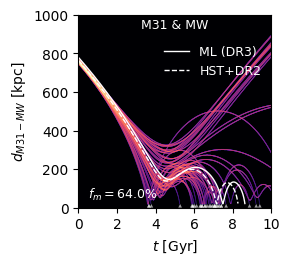

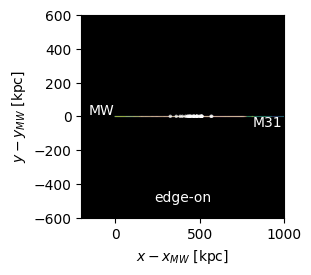

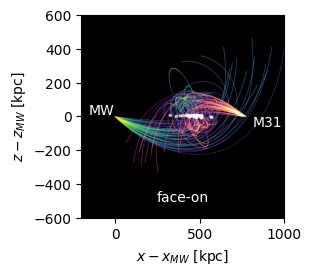

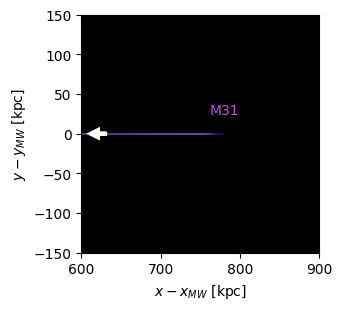

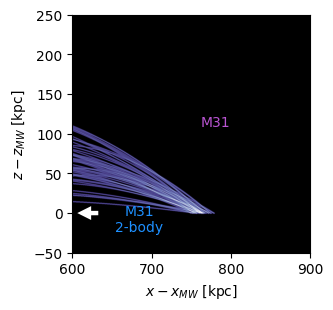

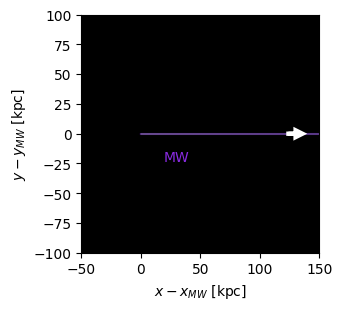

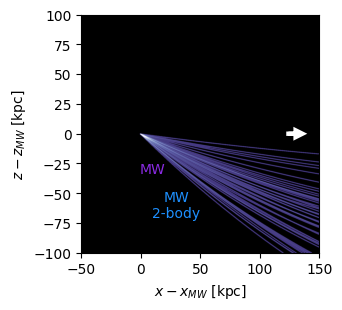

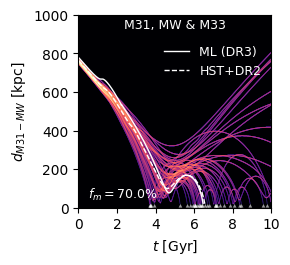

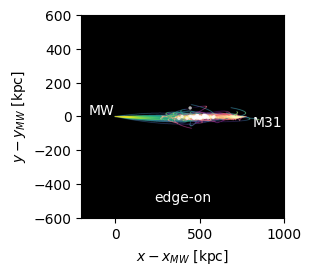

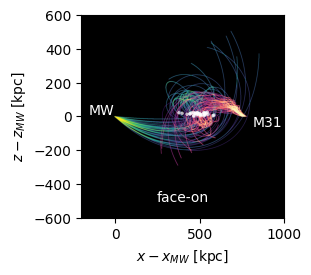

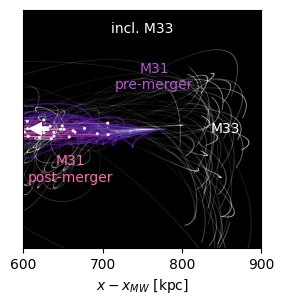

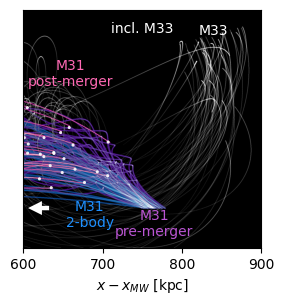

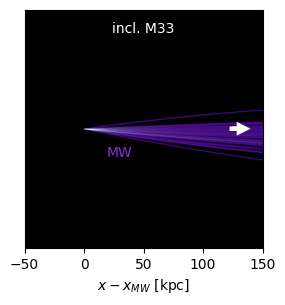

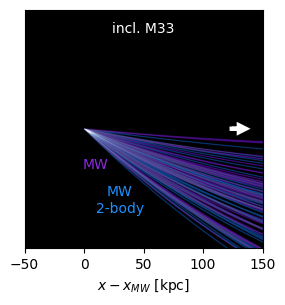

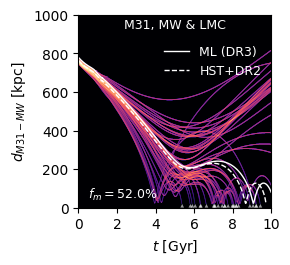

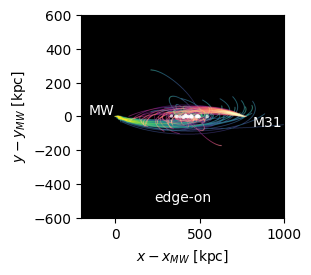

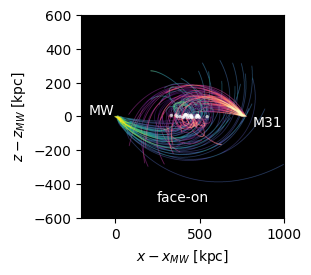

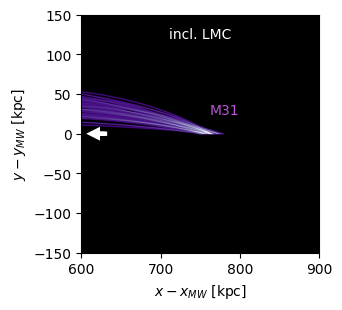

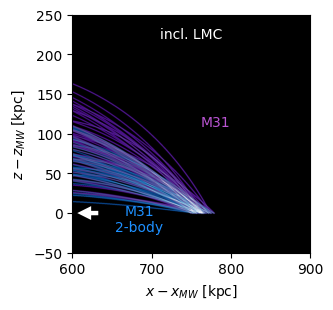

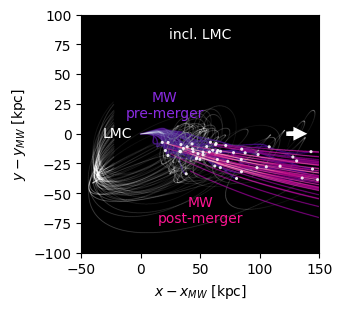

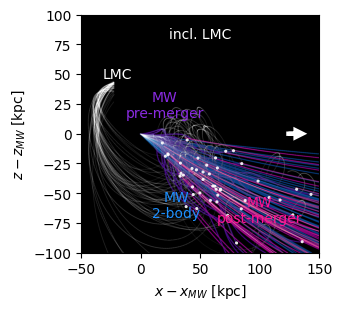

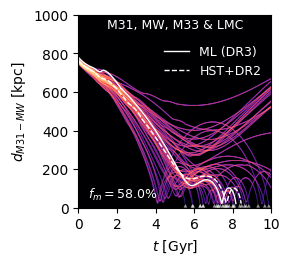

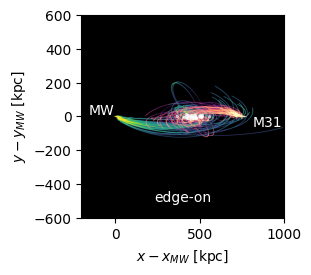

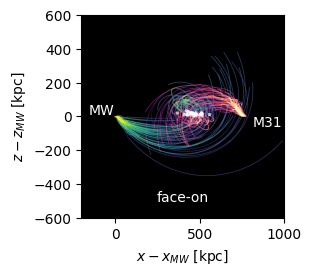

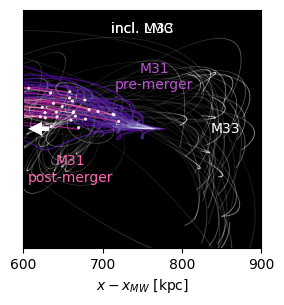

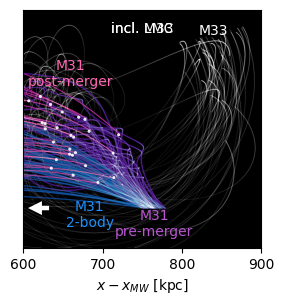

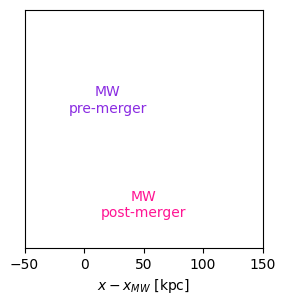

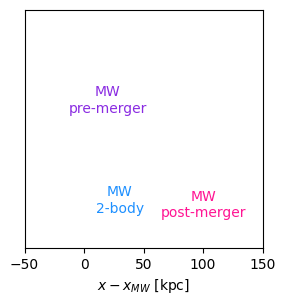

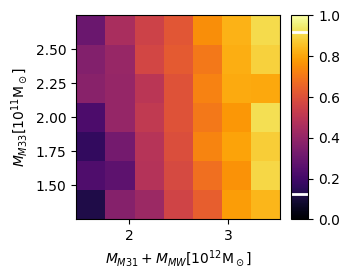

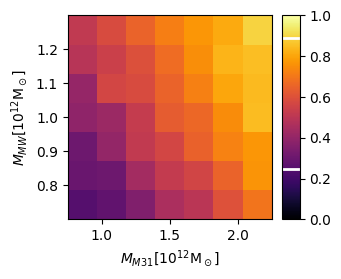

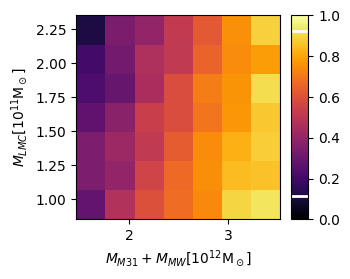

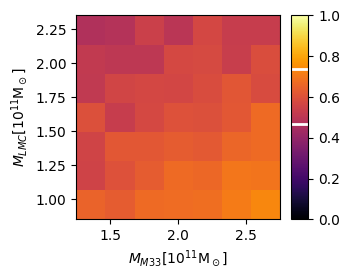

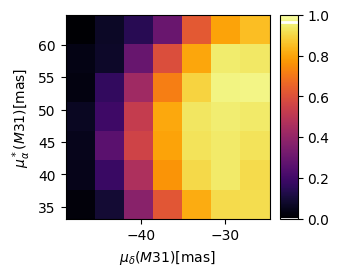

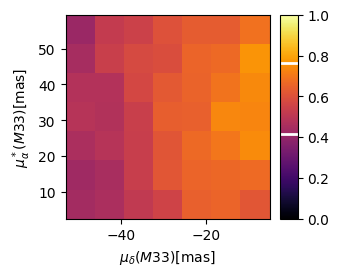

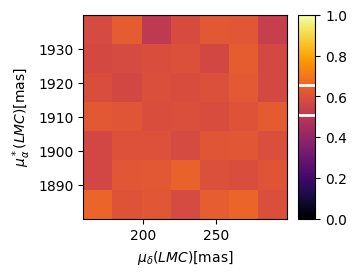

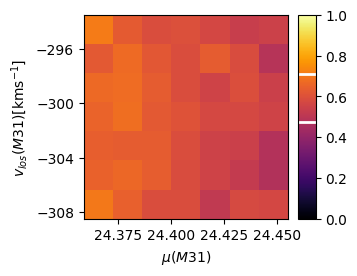

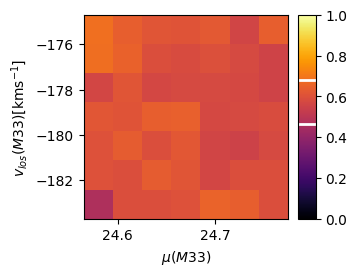

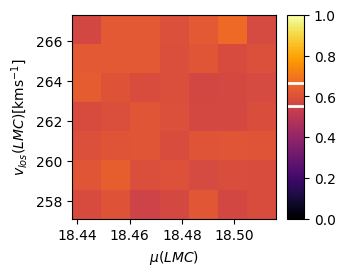

In [48]:

# color maps
cmapMW = cm.viridis
cmapMW.set_under('black')

cmapM31 = cm.magma
cmapM31.set_under('black')

cmapLMC = cm.Greys_r
cmapLMC.set_under('black')

cmapalt = cm.Blues_r
cmapalt.set_under('black')


cmapMW_premerger = cm.Purples_r
cmapMW_premerger.set_under('black')

cmapMW_postmerger = cm.RdPu_r
cmapMW_postmerger.set_under('black')


# Calculate the orbits and save them to files.
calculate_orbits = False
plot_figures = True
plot_animations = False
N_s = 50

variants = ['new']
galaxies_sets = [['M31','MW'],['M31', 'MW', 'M33'],['M31', 'MW', 'LMC'],['M31', 'MW', 'M33','LMC']]

clip_sigmas = [1.5]

if calculate_orbits:
    try:  
        os.mkdir(orbits_dir)  
    except OSError as error:  
        print(error) 
    Number_of_subsets = len(galaxies_sets)*len(variants)*len(dynamical_frictions)*len(clip_sigmas)
    Number_of_orbits = Number_of_subsets * N_s
    print ("computing "+str(Number_of_subsets)+" subsets with "+str(Number_of_orbits)+" total orbits. This will take some time.")
    
    compute_and_save()

# call functions for plotting the figures - these use either one or multiple sets of previously computed orbits.

if plot_figures:
    try:  
        os.mkdir(plots_dir)  
    except OSError as error:  
        print(error) 
    
# Plots that us only one dataset:
    
    for galaxies in galaxies_sets:
        for variant in variants:
            for dynamical_friction in dynamical_frictions:
                for clip_sigma in clip_sigmas:
                    
                    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

 #                   print ("galaxies", galaxies)
                    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, N_s)
                    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, N_s)

                    orbits = orbit_data['orbits']
                    vels = orbit_data['vels']

                    # plot the distance (Figure 1)
          #          plot_distances(galaxies, orbits, summary_data, suffix)

                    plot_distances_compare(galaxies, orbits, summary_data, suffix)
                  
                    plot_heatmap_MW_M31(orbits, vels, summary_data, suffix)
       #             plot the orbit of the Mw and M31 (Figure 1)

         #           plot_LMC_and_MW(galaxies, orbits, vels, summary_data, suffix)

    #                plot_M33_and_M31(galaxies, orbits, vels, summary_data, suffix)

                    orbit_data_alt = read_orbit_data(['M31','MW'], variant, dynamical_friction, clip_sigma, N_s)
                    orbits_alt = orbit_data_alt['orbits']

                    plot_M33_and_M31_compare(galaxies, orbits, vels, orbits_alt, summary_data, suffix)
                    plot_LMC_and_MW_compare(galaxies, orbits, vels, orbits_alt, summary_data, suffix)

    
# Plots that use multiple datasets - these need to be pre-computed

#    plot_stas_mergerfraction()

#    plot_stas_outcomes()

#    plot_2d_outcomes()


if plot_animations:
    try:  
        os.mkdir(animations_dir)  
    except OSError as error:  
        print(error) 
    
    for galaxies in galaxies_sets:
        for variant in variants:
            for dynamical_friction in dynamical_frictions:
                for clip_sigma in clip_sigmas:
                    
                    suffix = print_suffix(galaxies, variant, dynamical_friction, clip_sigma, N_s)

                    print ("galaxies", galaxies)
                    orbit_data = read_orbit_data(galaxies, variant, dynamical_friction, clip_sigma, N_s)
                    summary_data = read_summary_data(galaxies, variant, dynamical_friction, clip_sigma, N_s)

                    orbits = orbit_data['orbits']
                    vels = orbit_data['vels']

                    # plot the orbit of the Mw and M31 (Figure 1)
                    animate_heatmap_MW_M31_face_on(orbits, vels, summary_data, suffix)
    #                animate_heatmap_MW_M31_edge_on(orbits, vels, summary_data, suffix)

# Old things below

## Test M31 motion:

Reflex proper motion: (𝜇 𝛼 , 𝜇 𝛿 ) = (37.6 ± 0.6, −20.9 ±0.4) 𝜇as/yr. 
When subtracting 𝜇 from the corrected values, we thus
derive the final transverse velocity of M31 with respect to the centre
of the Milky Way. These values are provided in Table 5.

d = 785 kpc

we make use of the recent value of the motion of the Sun
with respect to the Galactic centre derived by Reid et al. (2019),
(𝑈 , 𝑉 + 𝑉𝑐 , 𝑊 ) = (10.6 ± 1.2, 247 ± 4, 7.6 ± 0.7) km s−1

Table 4. Transverse velocities corrected for apparent QSO motion and systematic method bias.

BPM

mu alpha 48.0 ± 10.2 uas
mu delta −38.4 ± 7.8 uas

v alpha: 178.7 km/s
v delta: −142.7
v trans: 231.1 

Table 5. Transverse velocities in non-rotating Galactic frame, centered on the Sun.

Mu alpha: 10.4 ± 10.3 uas
Mu delta: −17.5 ± 7.8
v alpha: 38.8
v delta: −65.0
v trans: 84.5 km/s


In [737]:
coo=(SkyCoord.from_name('M31'))
sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=785*u.kpc,
             pm_ra_cosdec=48.0*u.uas/u.yr, pm_dec= -38.4*u.uas/u.yr,radial_velocity=-301*u.km/u.s)

gal = sky.transform_to(Galactocentric(galcen_v_sun=(10.6, 247, 7.6)*u.km/u.s)) #convert ICRS coordinates to Galactocentric coordinates

pos = [gal.x.value,gal.y.value,gal.z.value] #positions array for the concerned galaxy
vel = [gal.v_x.value, gal.v_y.value, gal.v_z.value] #velocities array

print ("sky:", sky)
print ("gal:", gal)



v = np.linalg.norm(vel)
print ("total vel:", v)
vr = np.dot(pos,vel) / np.linalg.norm(pos)
print ("vr:", np.dot(pos,vel) / np.linalg.norm(pos))
vt = np.sqrt(v**2 - vr**2)
print ("vt:", vt)

coo=(SkyCoord.from_name('M31'))
sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=785*u.kpc,
             pm_ra_cosdec=48.0*u.uas/u.yr, pm_dec= -38.4*u.uas/u.yr,radial_velocity=-301*u.km/u.s)

gal = sky.transform_to(Galactocentric()) #convert ICRS coordinates to Galactocentric coordinates

pos = [gal.x.value,gal.y.value,gal.z.value] #positions array for the concerned galaxy
vel = [gal.v_x.value, gal.v_y.value, gal.v_z.value] #velocities array

print ("sky:", sky)
print ("gal:", gal)



v = np.linalg.norm(vel)
print ("total vel:", v)
vr = np.dot(pos,vel) / np.linalg.norm(pos)
print ("vr:", np.dot(pos,vel) / np.linalg.norm(pos))
vt = np.sqrt(v**2 - vr**2)
print ("vt:", vt)


sky: <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (10.6847083, 41.26875, 785.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.048, -0.0384, -301.)>
gal: <SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(10.6, 247., 7.6) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in kpc
    (-386.74353986, 624.59382527, -287.64786847)
 (v_x, v_y, v_z) in km / s
    (35.55174333, -129.17404094, -20.62083958)>
total vel: 135.5547060494753
vr: -112.17451602573892
vt: 76.10490317023532
sky: <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    (10.6847083, 41.26875, 785.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (0.048, -0.0384, -301.)>
gal: <SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20

In [29]:
pm_ra_cosdec_values = np.linspace(48-10.2,48+10.2,21)
pm_dec_values = np.linspace(-38.4-7.8,-38.4+7.8,21)

for i in range(20):
    for j in range(20):
        
        coo=(SkyCoord.from_name('M31'))
        sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=770*u.kpc,
                     pm_ra_cosdec=pm_ra_cosdec_values[i]*u.uas/u.yr, pm_dec= pm_dec_values[j]*u.uas/u.yr,radial_velocity=-301*u.km/u.s)
        
        gal = sky.transform_to(Galactocentric(galcen_v_sun=(10.6, 247, 7.6)*u.km/u.s)) #convert ICRS coordinates to Galactocentric coordinates
        
        pos = [gal.x.value,gal.y.value,gal.z.value] #positions array for the concerned galaxy
        vel = [gal.v_x.value, gal.v_y.value, gal.v_z.value] #velocities array
        
#        print ("sky:", sky)
#        print ("gal:", gal)
        v = np.linalg.norm(vel)
#        print ("total vel:", v)
        vr = np.dot(pos,vel) / np.linalg.norm(pos)
#        print ("vr:", np.dot(pos,vel) / np.linalg.norm(pos))
        vt = np.sqrt(v**2 - vr**2)
        if vt < 40 and vr < -105 and vr > -120:
            print ("pmra:", pm_ra_cosdec_values[i], "pmdec:", pm_dec_values[j], "vt:", vt, "vr:", vr)

print ("all done")

coo=(SkyCoord.from_name('M31'))
sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=770*u.kpc,
             pm_ra_cosdec=38.9*u.uas/u.yr, pm_dec= -32.2*u.uas/u.yr,radial_velocity=-301*u.km/u.s)

gal = sky.transform_to(Galactocentric(galcen_v_sun=(10.6, 247, 7.6)*u.km/u.s)) #convert ICRS coordinates to Galactocentric coordinates

pos = [gal.x.value,gal.y.value,gal.z.value] #positions array for the concerned galaxy
vel = [gal.v_x.value, gal.v_y.value, gal.v_z.value] #velocities array

#        print ("sky:", sky)
#        print ("gal:", gal)
v = np.linalg.norm(vel)
#        print ("total vel:", v)
vr = np.dot(pos,vel) / np.linalg.norm(pos)
#        print ("vr:", np.dot(pos,vel) / np.linalg.norm(pos))
vt = np.sqrt(v**2 - vr**2)
if vt < 40 and vr < -105 and vr > -120:
    print ("pmra:", pm_ra_cosdec_values[i], "pmdec:", pm_dec_values[j], "vt:", vt, "vr:", vr)


pmra: 37.8 pmdec: -32.16 vt: 39.3803716385954 vr: -112.47317136728773
pmra: 37.8 pmdec: -31.379999999999995 vt: 36.53396817980926 vr: -112.46655977486742
pmra: 38.82 pmdec: -32.16 vt: 39.47593542235856 vr: -112.44003355046044
pmra: 38.82 pmdec: -31.379999999999995 vt: 36.63695129035952 vr: -112.43342195804013
pmra: 39.839999999999996 pmdec: -32.16 vt: 39.92000765315815 vr: -112.40689573363315
pmra: 39.839999999999996 pmdec: -31.379999999999995 vt: 37.1150009460147 vr: -112.40028414121282
pmra: 40.86 pmdec: -31.379999999999995 vt: 37.95394731875478 vr: -112.3671463243855
pmra: 41.879999999999995 pmdec: -31.379999999999995 vt: 39.130584782348734 vr: -112.33400850755825
all done
pmra: 57.18000000000001 pmdec: -31.379999999999995 vt: 39.64380307814075 vr: -112.4377735620249


# Find the proper motions that give the smallest possible transverse velocity

In [30]:
pm_ra_cosdec_values = np.linspace(37.6,38.2,101)
pm_dec_values = np.linspace(-21.8,-21.2,101)

for i in range(100):
    for j in range(100):
        
        coo=(SkyCoord.from_name('M31'))
        sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=770*u.kpc,
                     pm_ra_cosdec=pm_ra_cosdec_values[i]*u.uas/u.yr, pm_dec= pm_dec_values[j]*u.uas/u.yr,radial_velocity=-301*u.km/u.s)
        
        gal = sky.transform_to(Galactocentric(galcen_v_sun=(10.6, 247, 7.6)*u.km/u.s)) #convert ICRS coordinates to Galactocentric coordinates
        
        pos = [gal.x.value,gal.y.value,gal.z.value] #positions array for the concerned galaxy
        vel = [gal.v_x.value, gal.v_y.value, gal.v_z.value] #velocities array
        
#        print ("sky:", sky)
#        print ("gal:", gal)
        v = np.linalg.norm(vel)
#        print ("total vel:", v)
        vr = np.dot(pos,vel) / np.linalg.norm(pos)
#        print ("vr:", np.dot(pos,vel) / np.linalg.norm(pos))
        vt = np.sqrt(v**2 - vr**2)
        if vt < 0.05 and vr < -105 and vr > -120:
            print ("pmra:", pm_ra_cosdec_values[i], "pmdec:", pm_dec_values[j], "vt:", vt, "vr:", vr)

print ("all done")

coo=(SkyCoord.from_name('M31'))
sky=SkyCoord(ra=coo.ra,dec=coo.dec,frame='icrs',distance=770*u.kpc,
             pm_ra_cosdec=38.9*u.uas/u.yr, pm_dec= -32.2*u.uas/u.yr,radial_velocity=-301*u.km/u.s)

gal = sky.transform_to(Galactocentric(galcen_v_sun=(10.6, 247, 7.6)*u.km/u.s)) #convert ICRS coordinates to Galactocentric coordinates

pos = [gal.x.value,gal.y.value,gal.z.value] #positions array for the concerned galaxy
vel = [gal.v_x.value, gal.v_y.value, gal.v_z.value] #velocities array

#        print ("sky:", sky)
#        print ("gal:", gal)
v = np.linalg.norm(vel)
#        print ("total vel:", v)
vr = np.dot(pos,vel) / np.linalg.norm(pos)
#        print ("vr:", np.dot(pos,vel) / np.linalg.norm(pos))
vt = np.sqrt(v**2 - vr**2)
if vt < 40 and vr < -105 and vr > -120:
    print ("pmra:", pm_ra_cosdec_values[i], "pmdec:", pm_dec_values[j], "vt:", vt, "vr:", vr)


pmra: 38.02 pmdec: -21.374 vt: 0.047267357203617626 vr: -112.37459753881883
pmra: 38.026 pmdec: -21.38 vt: 0.03394792458814711 vr: -112.37445346888781
pmra: 38.026 pmdec: -21.374 vt: 0.025371290653512603 vr: -112.37440261048455
pmra: 38.026 pmdec: -21.368 vt: 0.03307934862550815 vr: -112.37435175208132
pmra: 38.032000000000004 pmdec: -21.386 vt: 0.04460144809692818 vr: -112.37430939895677
pmra: 38.032000000000004 pmdec: -21.38 vt: 0.022830024857708877 vr: -112.3742585405535
pmra: 38.032000000000004 pmdec: -21.374 vt: 0.0035257639998459707 vr: -112.37420768215031
pmra: 38.032000000000004 pmdec: -21.368 vt: 0.021516321773946218 vr: -112.37415682374713
pmra: 38.032000000000004 pmdec: -21.362 vt: 0.043275550754945186 vr: -112.37410596534387
pmra: 38.038000000000004 pmdec: -21.386 vt: 0.048138204544805586 vr: -112.37411447062249
pmra: 38.038000000000004 pmdec: -21.38 vt: 0.029140826682673697 vr: -112.37406361221923
pmra: 38.038000000000004 pmdec: -21.374 vt: 0.018449632036118647 vr: -112.37

# Old IC generation